### Import Libraries

In [1]:
# General Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

# Algorithms (Regression)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as XGBoost
from prophet import Prophet
import skopt

# Preprocessing / Feature Selection / Model Selection / Metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

from multiprocessing import Pool, Process

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

pd.options.display.max_columns = 200

### Functions

In [3]:
# Функция для расчета метрик качества модели
def quality_metrics(y_true: float, y_pred: float) -> dict:
    dict_metrics = dict()
    dict_metrics['MSE'] = mean_squared_error(y_true, y_pred, squared=True)
    dict_metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    return dict_metrics

### Import data

In [4]:
test_data = pd.read_csv('test.csv')
test_data

MEAS_DT  Ni_1.1C_min  Ni_1.1C_max  Cu_1.1C_min  Cu_1.1C_max  \
0     2024-01-19 12:15:00          NaN          NaN          NaN          NaN   
1     2024-01-19 12:30:00          NaN          NaN          NaN          NaN   
2     2024-01-19 12:45:00          NaN          NaN          NaN          NaN   
3     2024-01-19 13:00:00          NaN          NaN          NaN          NaN   
4     2024-01-19 13:15:00          NaN          NaN          NaN          NaN   
...                   ...          ...          ...          ...          ...   
6735  2024-11-05 17:30:00          NaN          NaN          NaN          NaN   
6736  2024-11-05 17:45:00          NaN          NaN          NaN          NaN   
6737  2024-11-05 18:00:00          NaN          NaN          NaN          NaN   
6738  2024-11-05 18:15:00          NaN          NaN          NaN          NaN   
6739  2024-11-05 18:30:00          NaN          NaN          NaN          NaN   

      Ni_1.2C_min  Ni_1.2C_max  Cu_1.2C_min  Cu_1.2C_max  Cu_2.1T_min  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
6735          NaN          NaN          NaN          NaN          NaN   
6736          NaN          NaN          NaN          NaN          NaN   
6737          NaN          NaN          NaN          NaN          NaN   
6738          NaN          NaN          NaN          NaN          NaN   
6739          NaN          NaN          NaN          NaN          NaN   

      Cu_2.1T_max  Cu_2.2T_min  Cu_2.2T_max  Cu_3.1T_min  Cu_3.1T_max  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
6735          NaN          NaN          NaN          NaN          NaN   
6736          NaN          NaN          NaN          NaN          NaN   
6737          NaN          NaN          NaN          NaN          NaN   
6738          NaN          NaN          NaN          NaN          NaN   
6739          NaN          NaN          NaN          NaN          NaN   

      Cu_3.2T_min  Cu_3.2T_max  Ni_4.1T_min  Ni_4.1T_max  Ni_4.1C_min  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN          NaN          NaN   
...           ...          ...          ...          ...          ...   
6735          NaN          NaN          NaN          NaN          NaN   
6736          NaN          NaN          NaN          NaN          NaN   
6737          NaN          NaN          NaN          NaN          NaN   
6738          NaN          NaN          NaN          NaN          NaN   
6739          NaN          NaN          NaN          NaN          NaN   

      Ni_4.1C_max  Ni_4.2T_min  Ni_4.2T_max  Ni_4.2C_min  Ni_4.2C_max  \
0             NaN          NaN          NaN          NaN          NaN   
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4             NaN          NaN          NaN      

In [5]:
raw_data = pd.read_csv('df_rolling.csv')
raw_data.head()

MEAS_DT  Cu_oreth  Ni_oreth  Ore_mass       Mass_1      Mass_2  \
0  2024-01-01 00:00:00    2.6097    1.5313    1096.5  1240.597656  692.090942   
1  2024-01-01 00:15:00    2.5548    1.4842    1123.0  1205.422363  693.616394   
2  2024-01-01 00:30:00    2.5109    1.4355     840.0  1188.762573  698.350586   
3  2024-01-01 00:45:00    2.4765    1.3852     824.0  1151.888672  714.678101   
4  2024-01-01 01:00:00    2.3585    1.3368       0.0  1104.101318  730.190674   

     Dens_4      Mass_4       Vol_4   Cu_4F   Ni_4F  Ni_4.1C  Ni_4.1C_max  \
0  1.342155  711.999023  1548.71875  0.6232  2.4937   4.1826          4.7   
1  1.339809  710.697815  1556.56250  0.6292  2.5157   4.1037          4.7   
2  1.339792  707.198547  1548.09375  0.5941  2.5253   4.1911          4.7   
3  1.342392  707.865540  1538.87500  0.6682  2.5418   4.1268          4.7   
4  1.337608  700.935059  1545.18750  0.6489  2.5559   4.1805          4.7   

   Ni_4.1C_min  Ni_4.1T  Ni_4.1T_max  Ni_4.1T_min  FM_4.1_A  Ni_4.2C  \
0          4.5   0.7136         0.77         0.67       0.0   3.8121   
1          4.5   0.7247         0.77         0.67       0.0   3.7383   
2          4.5   0.7069         0.77         0.67       0.0   3.7132   
3          4.5   0.7097         0.77         0.67       0.0   3.7086   
4          4.5   0.7155         0.77         0.67       0.0   3.7558   

   Ni_4.2C_max  Ni_4.2C_min  Ni_4.2T  Ni_4.2T_max  Ni_4.2T_min  FM_4.2_A  \
0          4.7          4.2   0.7602         0.75         0.68       0.0   
1          4.7          4.2   0.7585         0.75         0.68       0.0   
2          4.7          4.2   0.7613         0.75         0.68       0.0   
3          4.7          4.2   0.7412         0.75         0.68       0.0   
4          4.7          4.2   0.7550         0.75         0.68       0.0   

     Dens_5      Mass_5        Vol_5    Ni_5F  Ni_5.1C  Ni_5.1C_max  \
0  1.346855  476.127625  1021.624939  3.99735   6.2100          6.5   
1  1.342700  473.042267  1027.312500  3.92100   6.3300          6.5   
2  1.342700  472.912659  1026.937500  3.95215   6.2619          6.5   
3  1.342075  475.598877  1034.750000  3.91770   6.0307          6.5   
4  1.340294  473.865509  1036.375000  3.96815   6.0333          6.5   

   Ni_5.1C_min  Ni_5.1T  Ni_5.1T_max  Ni_5.1T_min  FM_5.1_A  Ni_5.2C  \
0          6.3   0.7943         0.75         0.68       0.0   6.7906   
1          6.3   0.8009         0.75         0.68       0.0   6.6420   
2          6.3   0.7829         0.75         0.68       0.0   6.5325   
3          6.3   0.7576         0.75         0.68       0.0   6.7853   
4          6.3   0.7486         0.75         0.68       0.0   6.7513   

   Ni_5.2C_max  Ni_5.2C_min  Ni_5.2T  Ni_5.2T_max  Ni_5.2T_min  FM_5.2_A  \
0          6.5          6.3   0.7694         0.75         0.65       0.0   
1          6.5          6.3   0.7743         0.75         0.65       0.0   
2          6.5          6.3   0.7582         0.75         0.65       0.0   
3          6.5          6.3   0.7656         0.75         0.65       0.0   
4          6.5          6.3   0.7583         0.75         0.65       0.0   

     Dens_6      Mass_6      Vol_6    Ni_6F  Ni_6.1C  Ni_6.1C_max  \
0  1.344661  219.958878  474.96875  9.09595   9.0939          9.5   
1  1.335838  275.753723  611.09375  9.02795   9.0422          9.5   
2  1.312747  263.925659  626.93750  8.95510   8.9666          9.5   
3  1.317930  250.852905  586.18750  8.93175   8.9439          9.5   
4  1.311027  256.771332  615.59375  9.08420   9.1168          9.5   

   Ni_6.1C_min  Ni_6.1T  Ni_6.1T_max  Ni_6.1T_min  FM_6.1_A  Ni_6.2C  \
0          9.0   1.3531         1.45          1.4       0.0   9.0980   
1          9.0   1.3338         1.45          1.4       0.0   9.0137   
2          9.0   1.2827         1.45          1.4       0.0   8.9436   
3          9.0   1.3131         1.45          1.4       0.0   8.9196   
4          9.0   1.3491         1.45          1.4       0.0   9.0516   

   Ni_6.2C

In [6]:
X_test_opt = raw_data.query('MEAS_DT in @test_data.MEAS_DT').drop(['MEAS_DT', 'Ni_rec'], axis=1).reset_index(drop=True)

### Data Preprocessing

In [7]:
print('NaN amount in %')
raw_data.isna().sum() / raw_data.shape[0] * 100

NaN amount in %


MEAS_DT        0.0
Cu_oreth       0.0
Ni_oreth       0.0
Ore_mass       0.0
Mass_1         0.0
              ... 
Ni_3.2C_max    0.0
Ni_3.2C_min    0.0
Cu_3.2T_max    0.0
Cu_3.2T_min    0.0
Ni_rec         0.0
Length: 130, dtype: float64

### Clustering

In [9]:
points = pd.DataFrame(zip(raw_data.Ni_rec, np.linspace(0, 1, len(raw_data.Ni_rec))))

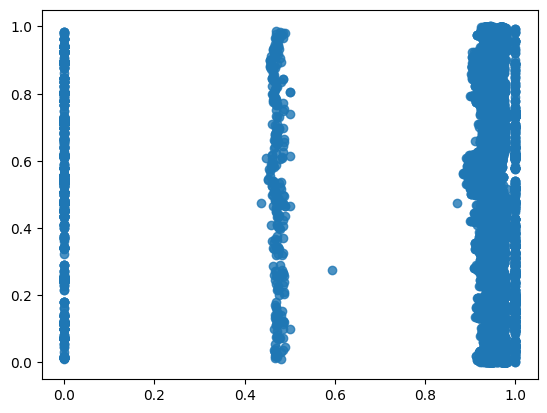

In [10]:
fig = plt.figure()
plt.scatter(points.iloc[:, 0], points.iloc[:, 1], marker='o', alpha=0.8) #
plt.show()

### Train / Validation / Test Datasets

In [11]:
# Отделяем данные, которые будут использоваться в качестве Train/Validation Dataset для обучения модели
X = raw_data.drop(['MEAS_DT', 'Ni_rec'], axis=1)
y = raw_data.Ni_rec
print(f'Количество данных для обучения и валидации модели: {X.shape[0]}')
print(f'Количество признаков для обучения и валидации модели: {X.shape[1]}')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, shuffle=False, random_state=42)

Количество данных для обучения и валидации модели: 30336
Количество признаков для обучения и валидации модели: 128


## Modelling

---
### Linear Regression

In [472]:
# Обучение модели
Lin_regressor = LinearRegression(n_jobs=-1)
grid_search_cv_linear = GridSearchCV(Lin_regressor, {}, cv=5)
grid_search_cv_linear.fit(X_train, y_train.to_numpy())

# Предсказание модели
y_pred_Linear_train = grid_search_cv_linear.best_estimator_.predict(X_train)
y_pred_Linear_test = grid_search_cv_linear.best_estimator_.predict(X_valid)

# Посчет метрик качества модели
for name_metric, error in quality_metrics(y_true=y_train, y_pred=y_pred_Linear_train).items():
    print(f'Train {name_metric}: {error:.5f}')

print()
lin_reg_metrics = quality_metrics(y_true=y_valid, y_pred=y_pred_Linear_test)
for name_metric, error in lin_reg_metrics.items():
    print(f'Test {name_metric}: {error:.5f}')

Train MSE: 0.01043
Train MAE: 0.06257

Test MSE: 0.04018
Test MAE: 0.16678


---
### Ridge Regression

In [478]:
# Обучение модели
Ridge_regressor = Ridge()
ridge_reg_parameters = {'alpha': np.logspace(-10, 1, 20)}
grid_search_cv_ridge = GridSearchCV(Ridge_regressor, ridge_reg_parameters, cv=5)

grid_search_cv_ridge.fit(X_train, y_train)
grid_search_cv_ridge.best_params_

# Предсказание модели
Ridge_best_reg = grid_search_cv_ridge.best_estimator_
y_pred_Ridge_train = Ridge_best_reg.predict(X_train)
y_pred_Ridge_test = Ridge_best_reg.predict(X_valid)

# Посчет метрик качества модели
for name_metric, error in quality_metrics(y_true=y_train, y_pred=y_pred_Ridge_train).items():
    print(f'Train {name_metric}: {error:.5f}')

ridge_metrics = quality_metrics(y_true=y_valid, y_pred=y_pred_Ridge_test)
for name_metric, error in ridge_metrics.items():
    print(f'Test {name_metric}: {error:.5f}')

Train MSE: 0.01065
Train MAE: 0.06318
Test MSE: 0.01272
Test MAE: 0.07108


---
### Random Forest Regression

In [479]:
# Обучение модели
Forest_regressor = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)
forest_reg_parameters = {'max_depth': np.arange(4, 20, 2)}
grid_search_cv_forest = GridSearchCV(Forest_regressor, forest_reg_parameters, cv=3)
grid_search_cv_forest.fit(X_train, y_train)
grid_search_cv_forest.best_params_

# Предсказание модели
Forest_best_reg = grid_search_cv_forest.best_estimator_
y_pred_Forest_train = Forest_best_reg.predict(X_train)
y_pred_Forest_test = Forest_best_reg.predict(X_valid)

# Посчет метрик качества модели
for name_metric, error in quality_metrics(y_true=y_train, y_pred=y_pred_Forest_train).items():
    print(f'Train {name_metric}: {error:.5f}')

print()
rforest_metrics = quality_metrics(y_true=y_valid, y_pred=y_pred_Forest_test)
for name_metric, error in rforest_metrics.items():
    print(f'Test {name_metric}: {error:.5f}')

Train MSE: 0.00050
Train MAE: 0.01121

Test MSE: 0.00407
Test MAE: 0.02521


---
### k-NN Regression

In [ ]:
# Обучение модели
KNeighbors_regressor = KNeighborsRegressor()
kNN_reg_parameters = {'n_neighbors': np.array(3, 6, 1)}                  # <- np.arange(2, 6, 1)
grid_search_cv_kNN = GridSearchCV(KNeighbors_regressor, kNN_reg_parameters, cv=5)
grid_search_cv_kNN.fit(X_train, y_train)
grid_search_cv_kNN.best_params_

# Предсказание модели
kNN_best_reg = grid_search_cv_kNN.best_estimator_
y_pred_kNN_train = kNN_best_reg.predict(X_train)
y_pred_kNN_test = kNN_best_reg.predict(X_valid)

# Посчет метрик качества модели
for name_metric, error in quality_metrics(y_true=y_train, y_pred=y_pred_kNN_train).items():
    print(f'Train {name_metric}: {error:.5f}')

print()
knn_metrics = quality_metrics(y_true=y_valid, y_pred=y_pred_kNN_test)
for name_metric, error in knn_metrics.items():
    print(f'Test {name_metric}: {error:.5f}')

Train MSE: 0.01001
Train MAE: 0.03337

Test MSE: 0.05759
Test MAE: 0.11661


---

### Boosting

In [482]:
# Обучение модели
GBoosting_regressor = GradientBoostingRegressor(n_estimators=50, max_depth=18)
gboost_reg_parameters = {}
grid_search_cv_gboost = GridSearchCV(GBoosting_regressor, gboost_reg_parameters, cv=5)
grid_search_cv_gboost.fit(X_train, y_train)
#print(grid_search_cv_gboost.best_params_)

# Предсказание модели
GBoost_best_reg = grid_search_cv_gboost.best_estimator_
y_pred_gboost_train = GBoost_best_reg.predict(X_train)
y_pred_gboost_test = GBoost_best_reg.predict(X_valid)

# Посчет метрик качества модели
for name_metric, error in quality_metrics(y_true=y_train, y_pred=y_pred_gboost_train).items():
    print(f'Train {name_metric}: {error:.5f}')

print()
gboost_metrics = quality_metrics(y_true=y_valid, y_pred=y_pred_gboost_test)
for name_metric, error in gboost_metrics.items():
    print(f'Test {name_metric}: {error:.5f}')


Train MSE: 0.00001
Train MAE: 0.00248

Test MSE: 0.00675
Test MAE: 0.03018


---

### MLP

In [12]:
import torch.nn.functional as F
import torch
import torchvision
import random
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import optuna
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

In [13]:
batch_size = 128 # Recomended range[16, 128]
input_size = X_train.shape[1] * batch_size
output_size = 1

# Train Loader
X_train_NN = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_NN = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
train_loader = torch.utils.data.DataLoader(list(zip(X_train_NN, y_train_NN)),
                                           batch_size=batch_size, 
                                           shuffle=True)

# Test Loader
X_test_NN = torch.tensor(X_valid.to_numpy(), dtype=torch.float32)
y_test_NN = torch.tensor(y_valid.to_numpy(), dtype=torch.float32).reshape(-1, 1)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_NN, y_test_NN)), 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [14]:
def epoch_train(loader, model, criterion, opt):
    model.train(True)
    average_loss = torch.tensor([]).to(device)

    for input, target in loader:
        input = input.to(device)
        target = target.to(device)
        #print(input.shape)
        # Forward
        output = model(input)
        loss = criterion(output, target)
        # Backward
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Average loss over one batch
        average_loss = torch.cat((average_loss, loss.reshape(1)), 0)
    
    # Average loss over all batches
    average_loss = average_loss.sum() / len(average_loss)

    return average_loss.item()

def epoch_test(loader, model, criterion, metric):
    # BEGIN Solution (do not delete this comment!)

    model.eval()
    average_loss = torch.tensor([]).to(device)
    average_l1_loss = torch.tensor([]).to(device)

    for input, target in loader:
      input = input.to(device)
      target = target.to(device)

      # Forward
      output = model(input)
      loss = criterion(output, target)
      l1_loss = metric(output, target)

      # Average loss over one batch
      average_loss = torch.cat((average_loss, loss.reshape(1)), 0)
      average_l1_loss = torch.cat((average_l1_loss, l1_loss.reshape(1)), 0)
    # Average loss over all batches
    average_loss = average_loss.sum() / len(average_loss)
    average_l1_loss = average_l1_loss.sum() / len(average_l1_loss)

    return average_loss.item(), average_l1_loss.item()

def train(train_loader, test_loader, model, criterion, metric, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss = epoch_train(train_loader, model, criterion, opt)
        test_loss, test_l1_loss = epoch_test(test_loader, model, criterion, metric)

        if (epoch+1) % 10 == 0:
            print(f'[Epoch {epoch+1}] train loss: {train_loss:.5f};   test loss: {test_loss:.5f}')
    
    return {'MSE': test_loss, 'MAE': test_l1_loss}

In [18]:
class MLP(torch.nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            #torch.nn.Flatten(),

            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),


            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),

            torch.nn.Linear(1024, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 4096),
            torch.nn.ReLU(),

            torch.nn.Linear(4096, 2048),
            torch.nn.BatchNorm1d(2048),
            torch.nn.Dropout(0.2),
            torch.nn.ReLU(),

            torch.nn.Linear(2048, 1024),            
            torch.nn.ReLU(),

            torch.nn.Linear(1024, num_outputs),
        )
    
    def forward(self, x):
        return self.layers(x)

In [19]:
model_MLP = MLP(num_inputs=input_size, num_outputs=output_size).to(device)
print('Number of weights:', np.sum([np.prod(param.shape) for param in model_MLP.parameters()]))

opt = torch.optim.Adam(model_MLP.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
metric = torch.nn.L1Loss()

Number of weights: 21581313


In [20]:
mlp_metrics = train(train_loader, test_loader, model_MLP, criterion, metric, opt, n_epochs=90)

 11%|█         | 10/90 [00:43<05:11,  3.89s/it]

[Epoch 10] train loss: 0.01222;   test loss: 0.03370


 22%|██▏       | 20/90 [01:21<04:20,  3.72s/it]

[Epoch 20] train loss: 0.00751;   test loss: 0.20777


 33%|███▎      | 30/90 [01:59<03:43,  3.73s/it]

[Epoch 30] train loss: 0.00738;   test loss: 0.00828


 44%|████▍     | 40/90 [02:37<03:08,  3.77s/it]

[Epoch 40] train loss: 0.00615;   test loss: 0.10851


 56%|█████▌    | 50/90 [03:15<02:26,  3.67s/it]

[Epoch 50] train loss: 0.00605;   test loss: 0.02707


 67%|██████▋   | 60/90 [03:53<01:50,  3.70s/it]

[Epoch 60] train loss: 0.00527;   test loss: 0.01754


 78%|███████▊  | 70/90 [04:30<01:14,  3.73s/it]

[Epoch 70] train loss: 0.00447;   test loss: 0.01534


 89%|████████▉ | 80/90 [05:07<00:35,  3.60s/it]

[Epoch 80] train loss: 0.00456;   test loss: 0.82044


100%|██████████| 90/90 [05:43<00:00,  3.82s/it]

[Epoch 90] train loss: 0.00391;   test loss: 0.02859


In [21]:
torch.save(model_MLP, 'full_model.pth')

In [24]:
model_MLP = torch.load('full_model.pth')
model_MLP.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=4096, bias=True)
    (9): ReLU()
    (10): Linear(in_features=4096, out_features=2048, bias=True)
    (11): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): ReLU()
    (14): Linear(in_features=2048, out_features=1024, bias=True)
    (15): ReLU()
    (16): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [28]:
cols_to_opt = [
    'Ni_1.1C_min', 'Ni_1.1C_max', 'Cu_1.1C_min', 'Cu_1.1C_max',
    'Ni_1.2C_min', 'Ni_1.2C_max', 'Cu_1.2C_min', 'Cu_1.2C_max',
    'Cu_2.1T_min', 'Cu_2.1T_max', 'Cu_2.2T_min', 'Cu_2.2T_max',
    'Cu_3.1T_min', 'Cu_3.1T_max', 'Cu_3.2T_min', 'Cu_3.2T_max',
    'Ni_4.1T_min', 'Ni_4.1T_max', 'Ni_4.1C_min', 'Ni_4.1C_max',
    'Ni_4.2T_min', 'Ni_4.2T_max', 'Ni_4.2C_min', 'Ni_4.2C_max',
    'Ni_5.1T_min', 'Ni_5.1T_max', 'Ni_5.1C_min', 'Ni_5.1C_max',
    'Ni_5.2T_min', 'Ni_5.2T_max', 'Ni_5.2C_min', 'Ni_5.2C_max',
    'Ni_6.1T_min', 'Ni_6.1T_max', 'Ni_6.1C_min', 'Ni_6.1C_max',
    'Ni_6.2T_min', 'Ni_6.2T_max', 'Ni_6.2C_min', 'Ni_6.2C_max']
mean_cols = ['Ni_1.1C', 'Cu_1.1C', 'Ni_1.2C', 'Cu_1.2C', 'Cu_2.1T', 'Cu_2.2T', 'Cu_3.1T', 'Cu_3.2T', 'Ni_4.1T', 'Ni_4.1C', 'Ni_4.2T', 'Ni_4.2C', 'Ni_5.1T', 'Ni_5.1C', 'Ni_5.2T', 'Ni_5.2C', 'Ni_6.1T', 'Ni_6.1C', 'Ni_6.2T', 'Ni_6.2C']

In [29]:
X_test_opt

Cu_oreth  Ni_oreth  Ore_mass       Mass_1      Mass_2    Dens_4  \
0       3.0800   1.79440    1268.5  1255.239380  763.164551  1.414601   
1       3.0994   1.78140    1034.5  1283.736450  760.610352  1.414352   
2       3.1011   1.73460    1160.5  1294.992554  758.174927  1.417581   
3       3.0749   1.69320    1213.5  1252.497437  758.151306  1.413983   
4       3.0465   1.66460    1270.0  1265.706177  756.448669  1.409195   
...        ...       ...       ...          ...         ...       ...   
6735    2.5019   1.46270     908.5  1247.026245  735.380615  1.375867   
6736    2.4273   1.41220     977.5  1215.475342  740.068298  1.368626   
6737    2.4646   1.43745    1045.5  1190.314697  737.474365  1.365812   
6738    2.4741   1.38220    1042.0  1230.502319  751.552673  1.358380   
6739    2.5808   1.35040    1062.5  1250.319092  757.391357  1.359597   

          Mass_4       Vol_4   Cu_4F    Ni_4F  Ni_4.1C  Ni_4.1C_max  \
0     822.913025  1476.09375  0.5986  2.74470   4.2114          4.3   
1     827.690430  1488.59375  0.5632  2.70930   4.2360          4.3   
2     832.063965  1482.96875  0.5732  2.73410   4.1946          4.3   
3     826.051880  1485.06250  0.5526  2.75020   4.2584          4.3   
4     818.806030  1489.21875  0.5488  2.73400   4.1174          4.3   
...          ...         ...     ...      ...      ...          ...   
6735  795.748108  1575.68750  0.4167  2.30730   4.6653          5.2   
6736  787.464417  1589.96875  0.4118  2.46150   4.6139          5.2   
6737  779.167542  1585.90625  0.3964  2.38035   4.5703          5.2   
6738  765.897705  1586.28125  0.2059  1.15365   4.6489          5.2   
6739  759.857666  1579.06250  0.4288  2.45800   4.6024          5.2   

      Ni_4.1C_min  Ni_4.1T  Ni_4.1T_max  Ni_4.1T_min  FM_4.1_A  Ni_4.2C  \
0             4.1  0.68830          0.7         0.65       1.0   4.3147   
1             4.1  0.69440          0.7         0.65       1.0   4.2632   
2             4.1  0.67870          0.7         0.65       1.0   4.2512   
3             4.1  0.70130          0.7         0.65       1.0   4.3323   
4             4.1  0.69210          0.7         0.65       1.0   4.2574   
...           ...      ...          ...          ...       ...      ...   
6735          4.0  0.71480          0.8         0.68       1.0   4.3139   
6736          4.0  0.71490          0.8         0.68       1.0   4.3246   
6737          4.0  0.71485          0.8         0.68       1.0   4.2155   
6738          4.0  0.70320          0.8         0.68       1.0   4.2768   
6739          4.0  0.70670          0.8         0.68       1.0   4.2750   

      Ni_4.2C_max  Ni_4.2C_min  Ni_4.2T  Ni_4.2T_max  Ni_4.2T_min  FM_4.2_A  \
0             4.5          4.1   0.6701         0.70         0.65       1.0   
1             4.5          4.1   0.6619         0.70         0.65       1.0   
2             4.5          4.1   0.6619         0.70         0.65       1.0   
3             4.5          4.1   0.6595         0.70         0.65       1.0   
4             4.5          4.1   0.6495         0.70         0.65       1.0   
...           ...          ...      ...          ...          ...       ...   
6735          4.7          4.0   0.7446         0.78         0.68       1.0   
6736          4.7          4.0   0.7391         0.78         0.68       1.0   
6737          4.7          4.0   0.7250         0.78         0.68       1.0   
6738          4.7          4.0   0.7403         0.78         0.68       1.0   
6739          4.7          4.0   0.7316         0.78         0.68       1.0   

        Dens_5      Mass_5      Vol_5    Ni_5F  Ni_5.1C  Ni_5.1C_max  \
0     1.383851  514.918945   996.7500  4.26305   6.2148          6.5   
1     1.385225  511.385010   989.7500  4.24960   6.2328          6.5   
2     1.379693  499.872894   979.8125  4.22290   6.2165          6.5   
3     1.380351  508.171051   992.5625  4.29535   6.1857          6.5   
4     1.384506  506.436096   987.3125  4.18740   6.2420          6

In [30]:
def function_to_minimize(*args) -> float:
    global X_opt, cols_to_opt, mean_cols
    """Function we want to minimize."""
    for i, col in enumerate(cols_to_opt):
        if i%2:
            X_opt[col] = X_opt[mean_cols[i//2]].mean() + args[i//2]
        else:
            X_opt[col] = X_opt[mean_cols[i//2]].mean() - args[i//2]

    # Prediction
    predict = model_MLP(torch.tensor(X_opt.to_numpy(), dtype=torch.float32, device=device))
    predict = predict.cpu().detach().numpy()
    
    return -predict.mean() + np.mean(args)

def objective(trial):
    global cols_to_opt, mean_cols
    input_args = []
    for col in mean_cols:
        input_args.append(trial.suggest_float(f'{col}', 0, 1))
    return function_to_minimize(*input_args)

In [ ]:
step = 10
for i in np.arange(0, len(X_test_opt), step):
    X_opt = X_test_opt.iloc[i:i+step, :]
    study = optuna.create_study()
    print(i)
    # n_trials - count of iterations.
    study.optimize(objective, n_trials=100)
    optuna_params = study.best_params

    for j, col in enumerate(cols_to_opt):
        if j % 2:
            test_data.iloc[i:i+step, j+1] = np.round(X_opt[mean_cols[j//2]].mean() + optuna_params[mean_cols[j//2]], 1)
        else:
            test_data.iloc[i:i+step, j+1] = np.round(X_opt[mean_cols[j//2]].mean() - optuna_params[mean_cols[j//2]], 1)

[I 2024-12-08 01:55:31,674] A new study created in memory with name: no-name-e001fc41-c036-45ac-9d5d-f5685af8f60f
[I 2024-12-08 01:55:31,705] Trial 0 finished with value: 0.058238676794388766 and parameters: {'Ni_1.1C': 0.1021927405874572, 'Cu_1.1C': 0.5418835408387532, 'Ni_1.2C': 0.48781415878925904, 'Cu_1.2C': 0.1136355258535795, 'Cu_2.1T': 0.2878483884788384, 'Cu_2.2T': 0.7438679317357385, 'Cu_3.1T': 0.8645976720934162, 'Cu_3.2T': 0.0874191710348462, 'Ni_4.1T': 0.9062081836854685, 'Ni_4.1C': 0.8286987449819562, 'Ni_4.2T': 0.024942311835194797, 'Ni_4.2C': 0.4746639768024974, 'Ni_5.1T': 0.5730420311638659, 'Ni_5.1C': 0.2694280328029687, 'Ni_5.2T': 0.4782981521563595, 'Ni_5.2C': 0.29951775760542587, 'Ni_6.1T': 0.9273161444516018, 'Ni_6.1C': 0.45619286363320255, 'Ni_6.2T': 0.6926032084277394, 'Ni_6.2C': 0.0589035455757253}. Best is trial 0 with value: 0.058238676794388766.
[I 2024-12-08 01:55:31,761] Trial 1 finished with value: 0.20707799106448377 and parameters: {'Ni_1.1C': 0.22558845

0


[I 2024-12-08 01:55:31,911] Trial 5 finished with value: 0.07614411667592669 and parameters: {'Ni_1.1C': 0.206237929453006, 'Cu_1.1C': 0.8313038640196905, 'Ni_1.2C': 0.789640971685509, 'Cu_1.2C': 0.40290406635804576, 'Cu_2.1T': 0.7939877732120609, 'Cu_2.2T': 0.22448754118251302, 'Cu_3.1T': 0.941954764795797, 'Cu_3.2T': 0.039043369565415986, 'Ni_4.1T': 0.9423771349600041, 'Ni_4.1C': 0.4572834409712785, 'Ni_4.2T': 0.010775459149329869, 'Ni_4.2C': 0.10707912273742115, 'Ni_5.1T': 0.5636718935622282, 'Ni_5.1C': 0.8262911956115246, 'Ni_5.2T': 0.4463752862825108, 'Ni_5.2C': 0.0028172235925990607, 'Ni_6.1T': 0.3840914168915568, 'Ni_6.1C': 0.6352266349494304, 'Ni_6.2T': 0.7865812582642089, 'Ni_6.2C': 0.7182196567150805}. Best is trial 4 with value: -0.10474947740791085.
[I 2024-12-08 01:55:31,962] Trial 6 finished with value: 0.26295655972366627 and parameters: {'Ni_1.1C': 0.014922488481243001, 'Cu_1.1C': 0.36693775634921255, 'Ni_1.2C': 0.3309938185959491, 'Cu_1.2C': 0.9538475834546092, 'Cu_2.1

100


[I 2024-12-08 01:55:43,061] Trial 8 finished with value: 0.24709338205106168 and parameters: {'Ni_1.1C': 0.03833317619616894, 'Cu_1.1C': 0.7468563768945599, 'Ni_1.2C': 0.4532601558758461, 'Cu_1.2C': 0.7444007021282593, 'Cu_2.1T': 0.0008448751460569115, 'Cu_2.2T': 0.8855787439460338, 'Cu_3.1T': 0.5515920952889386, 'Cu_3.2T': 0.4192124749146853, 'Ni_4.1T': 0.9642834878447097, 'Ni_4.1C': 0.10014921917913955, 'Ni_4.2T': 0.6405741323054401, 'Ni_4.2C': 0.8933477190003207, 'Ni_5.1T': 0.00015759499700829238, 'Ni_5.1C': 0.8982831182826676, 'Ni_5.2T': 0.2774754221426692, 'Ni_5.2C': 0.7426019149803815, 'Ni_6.1T': 0.4212398815955056, 'Ni_6.1C': 0.2617241748609148, 'Ni_6.2T': 0.596401367713057, 'Ni_6.2C': 0.536238864403068}. Best is trial 5 with value: -0.36413112598404995.
[I 2024-12-08 01:55:43,078] Trial 9 finished with value: 0.053039446107873145 and parameters: {'Ni_1.1C': 0.9847630692672302, 'Cu_1.1C': 0.1530502538410463, 'Ni_1.2C': 0.6330812097979541, 'Cu_1.2C': 0.010663756709922811, 'Cu_2.1

200


[I 2024-12-08 01:55:55,334] Trial 10 finished with value: -0.2170692846548028 and parameters: {'Ni_1.1C': 0.32179565869941884, 'Cu_1.1C': 0.6815101847159737, 'Ni_1.2C': 0.9677610085590109, 'Cu_1.2C': 0.033862873247614056, 'Cu_2.1T': 0.019126668286399306, 'Cu_2.2T': 0.027874950611017413, 'Cu_3.1T': 0.36083308499107886, 'Cu_3.2T': 0.7678073811531879, 'Ni_4.1T': 0.06158003345293872, 'Ni_4.1C': 0.6627724474266148, 'Ni_4.2T': 0.022489923904850828, 'Ni_4.2C': 0.9889460020069333, 'Ni_5.1T': 0.5969001679784449, 'Ni_5.1C': 0.42515114708168356, 'Ni_5.2T': 0.28912205684339376, 'Ni_5.2C': 0.6434708027813865, 'Ni_6.1T': 0.6234545424999667, 'Ni_6.1C': 0.3400134783654547, 'Ni_6.2T': 0.5168065412394461, 'Ni_6.2C': 0.7796873809521949}. Best is trial 7 with value: -0.4114093763510632.
[I 2024-12-08 01:55:55,490] Trial 11 finished with value: -0.28594825800059254 and parameters: {'Ni_1.1C': 0.04172432853076616, 'Cu_1.1C': 0.2379750563914752, 'Ni_1.2C': 0.3262281114492528, 'Cu_1.2C': 0.6514499419567583, '

300


[I 2024-12-08 01:56:06,647] Trial 8 finished with value: -0.08731001968144203 and parameters: {'Ni_1.1C': 0.19504865157455897, 'Cu_1.1C': 0.8125854047638578, 'Ni_1.2C': 0.49802180066848767, 'Cu_1.2C': 0.8702597496685377, 'Cu_2.1T': 0.45567604612137125, 'Cu_2.2T': 0.49138036698964016, 'Cu_3.1T': 0.2519709794503222, 'Cu_3.2T': 0.3067964785342311, 'Ni_4.1T': 0.3501767880511242, 'Ni_4.1C': 0.5396804663922745, 'Ni_4.2T': 0.6473956783730626, 'Ni_4.2C': 0.42408155222344845, 'Ni_5.1T': 0.04178039140645895, 'Ni_5.1C': 0.6697148576288159, 'Ni_5.2T': 0.157997797701668, 'Ni_5.2C': 0.7318586909021407, 'Ni_6.1T': 0.40949612987418316, 'Ni_6.1C': 0.8531990257122821, 'Ni_6.2T': 0.9103885986530987, 'Ni_6.2C': 0.8302131482025947}. Best is trial 1 with value: -0.5298428588060013.
[I 2024-12-08 01:56:06,672] Trial 9 finished with value: -0.2166826331095768 and parameters: {'Ni_1.1C': 0.7669816232457738, 'Cu_1.1C': 0.9694273228171411, 'Ni_1.2C': 0.2539708225394848, 'Cu_1.2C': 0.5656753619356972, 'Cu_2.1T': 

400


[I 2024-12-08 01:56:17,877] Trial 8 finished with value: -0.25000908716806713 and parameters: {'Ni_1.1C': 0.10214699684262263, 'Cu_1.1C': 0.8811518588065707, 'Ni_1.2C': 0.5771408967036158, 'Cu_1.2C': 0.6782693324032006, 'Cu_2.1T': 0.48442662194216723, 'Cu_2.2T': 0.6408806182981901, 'Cu_3.1T': 0.994698181330955, 'Cu_3.2T': 0.8825730463974019, 'Ni_4.1T': 0.5703457654795463, 'Ni_4.1C': 0.8484249412275684, 'Ni_4.2T': 0.6632656097789796, 'Ni_4.2C': 0.6091434298376359, 'Ni_5.1T': 0.5702303299034963, 'Ni_5.1C': 0.4415516701482969, 'Ni_5.2T': 0.2755409887753969, 'Ni_5.2C': 0.19990359255109236, 'Ni_6.1T': 0.6718884653790919, 'Ni_6.1C': 0.6255207963871758, 'Ni_6.2T': 0.8704499939255727, 'Ni_6.2C': 0.0635045156616818}. Best is trial 6 with value: -0.4768298156084677.
[I 2024-12-08 01:56:17,895] Trial 9 finished with value: -0.4005536910788054 and parameters: {'Ni_1.1C': 0.3666570044867361, 'Cu_1.1C': 0.6308550055656593, 'Ni_1.2C': 0.7874386439368685, 'Cu_1.2C': 0.5308493269496907, 'Cu_2.1T': 0.34

500


[I 2024-12-08 01:56:29,364] Trial 9 finished with value: -0.4221371014278702 and parameters: {'Ni_1.1C': 0.9422552042942952, 'Cu_1.1C': 0.6596832418614681, 'Ni_1.2C': 0.09056920227464726, 'Cu_1.2C': 0.3365689117058428, 'Cu_2.1T': 0.8340965802825475, 'Cu_2.2T': 0.46617355891528267, 'Cu_3.1T': 0.6623757624609954, 'Cu_3.2T': 0.6752452569158767, 'Ni_4.1T': 0.09794189521557095, 'Ni_4.1C': 0.5227017660927632, 'Ni_4.2T': 0.28871081531969756, 'Ni_4.2C': 0.6508815438626068, 'Ni_5.1T': 0.036007018574224725, 'Ni_5.1C': 0.9131648419824248, 'Ni_5.2T': 0.4860119261973528, 'Ni_5.2C': 0.9120539921368962, 'Ni_6.1T': 0.01646358016164129, 'Ni_6.1C': 0.02538729137451956, 'Ni_6.2T': 0.7456656741697584, 'Ni_6.2C': 0.6786621055201606}. Best is trial 2 with value: -0.5221734088113099.
[I 2024-12-08 01:56:29,591] Trial 10 finished with value: -0.5647288766655891 and parameters: {'Ni_1.1C': 0.056006724562227855, 'Cu_1.1C': 0.11628450113558275, 'Ni_1.2C': 0.9945058979212728, 'Cu_1.2C': 0.4934013496111695, 'Cu_2.

600


[I 2024-12-08 01:56:40,143] Trial 9 finished with value: -0.3594185008327426 and parameters: {'Ni_1.1C': 0.30810799745599093, 'Cu_1.1C': 0.2479255135826407, 'Ni_1.2C': 0.7719425726054517, 'Cu_1.2C': 0.7180680787349991, 'Cu_2.1T': 0.8902830743190869, 'Cu_2.2T': 0.3213344587288257, 'Cu_3.1T': 0.9991939021853161, 'Cu_3.2T': 0.6505998819591498, 'Ni_4.1T': 0.14310270355814514, 'Ni_4.1C': 0.7508879574967651, 'Ni_4.2T': 0.1606215631314426, 'Ni_4.2C': 0.2347160550551638, 'Ni_5.1T': 0.9336523258444883, 'Ni_5.1C': 0.5487998243903391, 'Ni_5.2T': 0.5993663099282399, 'Ni_5.2C': 0.6502676977806642, 'Ni_6.1T': 0.40251560001891085, 'Ni_6.1C': 0.7682441213263679, 'Ni_6.2T': 0.6492481109987284, 'Ni_6.2C': 0.6423187129736794}. Best is trial 6 with value: -0.4946033118217709.
[I 2024-12-08 01:56:40,263] Trial 10 finished with value: -0.3019368797757143 and parameters: {'Ni_1.1C': 0.018924575536536148, 'Cu_1.1C': 0.9482764404399132, 'Ni_1.2C': 0.5545923778230853, 'Cu_1.2C': 0.3791824566667198, 'Cu_2.1T': 0

700


[I 2024-12-08 01:56:51,078] Trial 8 finished with value: -0.29813808689477916 and parameters: {'Ni_1.1C': 0.2506945632696971, 'Cu_1.1C': 0.25592755669318146, 'Ni_1.2C': 0.001674401387023905, 'Cu_1.2C': 0.49457355281808457, 'Cu_2.1T': 0.6842904835282353, 'Cu_2.2T': 0.8031783436329113, 'Cu_3.1T': 0.2665422469928035, 'Cu_3.2T': 0.6382007894541059, 'Ni_4.1T': 0.3698012708089561, 'Ni_4.1C': 0.5068562549625681, 'Ni_4.2T': 0.8791593541818095, 'Ni_4.2C': 0.5153157082842639, 'Ni_5.1T': 0.5587768126818314, 'Ni_5.1C': 0.43382682011924334, 'Ni_5.2T': 0.0571370929009577, 'Ni_5.2C': 0.6694247015139219, 'Ni_6.1T': 0.7150249503709779, 'Ni_6.1C': 0.27390655674655573, 'Ni_6.2T': 0.8182360941646284, 'Ni_6.2C': 0.8262111219450757}. Best is trial 3 with value: -0.5350581146423792.
[I 2024-12-08 01:56:51,109] Trial 9 finished with value: -0.2551790403179329 and parameters: {'Ni_1.1C': 0.25692246785895656, 'Cu_1.1C': 0.8605775295091729, 'Ni_1.2C': 0.19406688135745664, 'Cu_1.2C': 0.9059611836896899, 'Cu_2.1T'

800


[I 2024-12-08 01:57:02,659] Trial 4 finished with value: -0.31905870056669916 and parameters: {'Ni_1.1C': 0.37420264703399686, 'Cu_1.1C': 0.01275767602119593, 'Ni_1.2C': 0.3436246698762483, 'Cu_1.2C': 0.23518721974927137, 'Cu_2.1T': 0.1286692259983956, 'Cu_2.2T': 0.45493380437576814, 'Cu_3.1T': 0.4576321084011795, 'Cu_3.2T': 0.9101081647843084, 'Ni_4.1T': 0.5232706156500172, 'Ni_4.1C': 0.6493956580485887, 'Ni_4.2T': 0.1793235929504241, 'Ni_4.2C': 0.5098031908806545, 'Ni_5.1T': 0.010476966716068237, 'Ni_5.1C': 0.05690112620324028, 'Ni_5.2T': 0.5168337115988259, 'Ni_5.2C': 0.14082530181749942, 'Ni_6.1T': 0.021164090930392176, 'Ni_6.1C': 0.8971707828279312, 'Ni_6.2T': 0.9450551207417742, 'Ni_6.2C': 0.5717339110908763}. Best is trial 4 with value: -0.31905870056669916.
[I 2024-12-08 01:57:02,693] Trial 5 finished with value: -0.3068459436651457 and parameters: {'Ni_1.1C': 0.860889058256475, 'Cu_1.1C': 0.9780818690199384, 'Ni_1.2C': 0.22695984126141577, 'Cu_1.2C': 0.01799236552939487, 'Cu_2

900


[I 2024-12-08 01:57:14,343] Trial 9 finished with value: -0.18319798980611035 and parameters: {'Ni_1.1C': 0.5254774265728569, 'Cu_1.1C': 0.8080234270084371, 'Ni_1.2C': 0.593329354611469, 'Cu_1.2C': 0.7430722444558772, 'Cu_2.1T': 0.9094449648952107, 'Cu_2.2T': 0.6837467328519967, 'Cu_3.1T': 0.5510614572083322, 'Cu_3.2T': 0.580263865339559, 'Ni_4.1T': 0.8614917537360189, 'Ni_4.1C': 0.3050921023203401, 'Ni_4.2T': 0.6134216835008708, 'Ni_4.2C': 0.8084687165760913, 'Ni_5.1T': 0.625657910399845, 'Ni_5.1C': 0.3658052911149817, 'Ni_5.2T': 0.822462669506992, 'Ni_5.2C': 0.24232569105731838, 'Ni_6.1T': 0.245144418536422, 'Ni_6.1C': 0.584037338690743, 'Ni_6.2T': 0.46121542491305423, 'Ni_6.2C': 0.9005900519772498}. Best is trial 4 with value: -0.6004554253491957.
[I 2024-12-08 01:57:14,501] Trial 10 finished with value: -0.5506265730988898 and parameters: {'Ni_1.1C': 0.0659173042596587, 'Cu_1.1C': 0.1461848742424544, 'Ni_1.2C': 0.26860278352291656, 'Cu_1.2C': 0.9553794014377208, 'Cu_2.1T': 0.106847

1000


[I 2024-12-08 01:57:26,552] Trial 8 finished with value: -0.5237687497507293 and parameters: {'Ni_1.1C': 0.8733517340249933, 'Cu_1.1C': 0.6815261995348855, 'Ni_1.2C': 0.6360230094074119, 'Cu_1.2C': 0.3014791897828665, 'Cu_2.1T': 0.5576379996469546, 'Cu_2.2T': 0.1466181538900101, 'Cu_3.1T': 0.1612121659373914, 'Cu_3.2T': 0.6944144796071131, 'Ni_4.1T': 0.3569771287064084, 'Ni_4.1C': 0.08774603142606086, 'Ni_4.2T': 0.6555052163375533, 'Ni_4.2C': 0.13657512998129195, 'Ni_5.1T': 0.5175378338577393, 'Ni_5.1C': 0.24378308044729613, 'Ni_5.2T': 0.2233163466064031, 'Ni_5.2C': 0.06761874191788697, 'Ni_6.1T': 0.5190754107066466, 'Ni_6.1C': 0.9533222325799863, 'Ni_6.2T': 0.2321401104836136, 'Ni_6.2C': 0.16841629936071345}. Best is trial 8 with value: -0.5237687497507293.
[I 2024-12-08 01:57:26,577] Trial 9 finished with value: -0.21426241422973125 and parameters: {'Ni_1.1C': 0.06045214796263765, 'Cu_1.1C': 0.7485314962473515, 'Ni_1.2C': 0.9602969783688224, 'Cu_1.2C': 0.08070378990424909, 'Cu_2.1T':

1100


[I 2024-12-08 01:57:39,074] Trial 9 finished with value: 0.3425985527434994 and parameters: {'Ni_1.1C': 0.016795180355998807, 'Cu_1.1C': 0.9591156414945602, 'Ni_1.2C': 0.3466956956668453, 'Cu_1.2C': 0.7610055434413944, 'Cu_2.1T': 0.8258500927987558, 'Cu_2.2T': 0.4998212508129152, 'Cu_3.1T': 0.3466874662543573, 'Cu_3.2T': 0.17418738806194078, 'Ni_4.1T': 0.6435426931159016, 'Ni_4.1C': 0.7827493429016684, 'Ni_4.2T': 0.28289841418589157, 'Ni_4.2C': 0.1389223934428624, 'Ni_5.1T': 0.920552817837486, 'Ni_5.1C': 0.12116075593577114, 'Ni_5.2T': 0.9301947034151617, 'Ni_5.2C': 0.1780063728739668, 'Ni_6.1T': 0.3888642351124395, 'Ni_6.1C': 0.7184402233929728, 'Ni_6.2T': 0.6022786959989691, 'Ni_6.2C': 0.649607640552723}. Best is trial 4 with value: 0.09180722086976767.
[I 2024-12-08 01:57:39,241] Trial 10 finished with value: 0.1841923348760064 and parameters: {'Ni_1.1C': 0.30041734247387747, 'Cu_1.1C': 0.05262270787749124, 'Ni_1.2C': 0.9767674051636102, 'Cu_1.2C': 0.2418898818860119, 'Cu_2.1T': 0.0

1200


[I 2024-12-08 01:57:51,764] Trial 7 finished with value: 0.42797609570920825 and parameters: {'Ni_1.1C': 0.7686197391523687, 'Cu_1.1C': 0.31215539719466967, 'Ni_1.2C': 0.28937860187234576, 'Cu_1.2C': 0.04927182121963114, 'Cu_2.1T': 0.8610122313314321, 'Cu_2.2T': 0.8471998962139244, 'Cu_3.1T': 0.8110010916841285, 'Cu_3.2T': 0.5761802973843976, 'Ni_4.1T': 0.17331052100585087, 'Ni_4.1C': 0.0032235292520468306, 'Ni_4.2T': 0.9497109207869349, 'Ni_4.2C': 0.09576453913570293, 'Ni_5.1T': 0.9345437392850506, 'Ni_5.1C': 0.8255372897848265, 'Ni_5.2T': 0.2946629535398383, 'Ni_5.2C': 0.5509028304481062, 'Ni_6.1T': 0.06147422215908116, 'Ni_6.1C': 0.7225207403427026, 'Ni_6.2T': 0.18755286779405833, 'Ni_6.2C': 0.3812090879202419}. Best is trial 2 with value: 0.33103699797007574.
[I 2024-12-08 01:57:51,801] Trial 8 finished with value: 0.44153400191295766 and parameters: {'Ni_1.1C': 0.36895666097083, 'Cu_1.1C': 0.4061227529173963, 'Ni_1.2C': 0.36130283279866027, 'Cu_1.2C': 0.3342724970828973, 'Cu_2.1T'

1300


[I 2024-12-08 01:58:04,245] Trial 4 finished with value: 0.39325317599145737 and parameters: {'Ni_1.1C': 0.20884858444857657, 'Cu_1.1C': 0.7689776954580276, 'Ni_1.2C': 0.9723768220359639, 'Cu_1.2C': 0.203797244939817, 'Cu_2.1T': 0.20810641234773497, 'Cu_2.2T': 0.07848003312349894, 'Cu_3.1T': 0.00997633428221989, 'Cu_3.2T': 0.4573684343836798, 'Ni_4.1T': 0.17142399920964813, 'Ni_4.1C': 0.3765550478923323, 'Ni_4.2T': 0.8957104422453761, 'Ni_4.2C': 0.8110739398022382, 'Ni_5.1T': 0.5399629124261132, 'Ni_5.1C': 0.07351194863921029, 'Ni_5.2T': 0.6512405854855854, 'Ni_5.2C': 0.6322663110863919, 'Ni_6.1T': 0.24786882349305162, 'Ni_6.1C': 0.11189285559991824, 'Ni_6.2T': 0.5740231712074892, 'Ni_6.2C': 0.6907998893707806}. Best is trial 1 with value: 0.20539853628615534.
[I 2024-12-08 01:58:04,271] Trial 5 finished with value: 0.44380148504858996 and parameters: {'Ni_1.1C': 0.5628247948164894, 'Cu_1.1C': 0.1196118729801976, 'Ni_1.2C': 0.2965714383947724, 'Cu_1.2C': 0.5116343872756336, 'Cu_2.1T': 

1400


[I 2024-12-08 01:58:17,496] Trial 8 finished with value: 0.4908179650057366 and parameters: {'Ni_1.1C': 0.8364879265171045, 'Cu_1.1C': 0.9467519433070886, 'Ni_1.2C': 0.5877244146244213, 'Cu_1.2C': 0.22653476639209713, 'Cu_2.1T': 0.44659891202445123, 'Cu_2.2T': 0.4012287927066358, 'Cu_3.1T': 0.6352211807735749, 'Cu_3.2T': 0.26579528189514545, 'Ni_4.1T': 0.7905189494437278, 'Ni_4.1C': 0.6229602850224578, 'Ni_4.2T': 0.6767690637884256, 'Ni_4.2C': 0.10003604434635927, 'Ni_5.1T': 0.9245605231709635, 'Ni_5.1C': 0.6492214819196346, 'Ni_5.2T': 0.15866283032067996, 'Ni_5.2C': 0.572250802139094, 'Ni_6.1T': 0.9683775927544426, 'Ni_6.1C': 0.8148299085493788, 'Ni_6.2T': 0.2511971018861787, 'Ni_6.2C': 0.2643397943550124}. Best is trial 1 with value: 0.1847590350869336.
[I 2024-12-08 01:58:17,527] Trial 9 finished with value: 0.04690601797999516 and parameters: {'Ni_1.1C': 0.6818777526335272, 'Cu_1.1C': 0.5322461943718426, 'Ni_1.2C': 0.12393362610904479, 'Cu_1.2C': 0.9878602164598618, 'Cu_2.1T': 0.00

1500


[I 2024-12-08 01:58:31,366] Trial 8 finished with value: 0.340263938454924 and parameters: {'Ni_1.1C': 0.8861373372571572, 'Cu_1.1C': 0.6725564112563711, 'Ni_1.2C': 0.5772374777975816, 'Cu_1.2C': 0.06725178444368085, 'Cu_2.1T': 0.31834256490841417, 'Cu_2.2T': 0.6644831099869597, 'Cu_3.1T': 0.8232150722205298, 'Cu_3.2T': 0.5577802082063424, 'Ni_4.1T': 0.30258071972277234, 'Ni_4.1C': 0.7221899249354867, 'Ni_4.2T': 0.6384487493709609, 'Ni_4.2C': 0.3469479853952967, 'Ni_5.1T': 0.2631130358055709, 'Ni_5.1C': 0.941353639600939, 'Ni_5.2T': 0.9870350482860424, 'Ni_5.2C': 0.6986438838789084, 'Ni_6.1T': 0.558790697791048, 'Ni_6.1C': 0.6110353732481089, 'Ni_6.2T': 0.265061896840861, 'Ni_6.2C': 0.849596262829744}. Best is trial 4 with value: 0.09277250804203901.
[I 2024-12-08 01:58:31,391] Trial 9 finished with value: 0.12427948720804388 and parameters: {'Ni_1.1C': 0.3001093603512841, 'Cu_1.1C': 0.16481647358981955, 'Ni_1.2C': 0.42130886515451693, 'Cu_1.2C': 0.43725977556456674, 'Cu_2.1T': 0.63371

1600


[I 2024-12-08 01:58:44,432] Trial 8 finished with value: 0.13200831008872926 and parameters: {'Ni_1.1C': 0.6374536089129224, 'Cu_1.1C': 0.6273631474740518, 'Ni_1.2C': 0.3834937637047029, 'Cu_1.2C': 0.8851753124525044, 'Cu_2.1T': 0.3619740680244523, 'Cu_2.2T': 0.3846123603932631, 'Cu_3.1T': 0.5062427455983847, 'Cu_3.2T': 0.5285990962815833, 'Ni_4.1T': 0.5556981815710661, 'Ni_4.1C': 0.48353043194525824, 'Ni_4.2T': 0.013931831670268569, 'Ni_4.2C': 0.13065155433364162, 'Ni_5.1T': 0.6155048774204424, 'Ni_5.1C': 0.7189512558172112, 'Ni_5.2T': 0.9633774050663104, 'Ni_5.2C': 0.30620599848271934, 'Ni_6.1T': 0.5474148828185589, 'Ni_6.1C': 0.8926432699557685, 'Ni_6.2T': 0.04256128973330875, 'Ni_6.2C': 0.09336070328619717}. Best is trial 1 with value: -0.05253395370916347.
[I 2024-12-08 01:58:44,456] Trial 9 finished with value: -0.01617544688029876 and parameters: {'Ni_1.1C': 0.9203045929473498, 'Cu_1.1C': 0.007499607615325532, 'Ni_1.2C': 0.6784654922190014, 'Cu_1.2C': 0.07353164581213001, 'Cu_2.

1700


[I 2024-12-08 01:58:57,305] Trial 7 finished with value: -0.14859596399414987 and parameters: {'Ni_1.1C': 0.4030287473627049, 'Cu_1.1C': 0.25186134742949506, 'Ni_1.2C': 0.8203235231680753, 'Cu_1.2C': 0.6101222768744466, 'Cu_2.1T': 0.6715854214373775, 'Cu_2.2T': 0.826757125547695, 'Cu_3.1T': 0.9868378046300024, 'Cu_3.2T': 0.6528501729671788, 'Ni_4.1T': 0.31402269134520555, 'Ni_4.1C': 0.6118817119319835, 'Ni_4.2T': 0.34380205260580377, 'Ni_4.2C': 0.07645710063742084, 'Ni_5.1T': 0.65308343789273, 'Ni_5.1C': 0.2861754970194059, 'Ni_5.2T': 0.18674426052894255, 'Ni_5.2C': 0.8125369596768096, 'Ni_6.1T': 0.27837886332387396, 'Ni_6.1C': 0.6257263304469894, 'Ni_6.2T': 0.6941757097652329, 'Ni_6.2C': 0.3324195163056597}. Best is trial 0 with value: -0.15782351528749594.
[I 2024-12-08 01:58:57,329] Trial 8 finished with value: 0.23027310912104715 and parameters: {'Ni_1.1C': 0.9406788781064319, 'Cu_1.1C': 0.959970495689181, 'Ni_1.2C': 0.3060749487281329, 'Cu_1.2C': 0.3122441550443801, 'Cu_2.1T': 0.5

1800


[I 2024-12-08 01:59:10,621] Trial 5 finished with value: -0.15211469234551078 and parameters: {'Ni_1.1C': 0.4211181233446609, 'Cu_1.1C': 0.603639448128228, 'Ni_1.2C': 0.4132105419980665, 'Cu_1.2C': 0.1710029260089756, 'Cu_2.1T': 0.09943536087392968, 'Cu_2.2T': 0.9490970679170665, 'Cu_3.1T': 0.8287370774798061, 'Cu_3.2T': 0.5910403773605175, 'Ni_4.1T': 0.18722767617336533, 'Ni_4.1C': 0.4002316769451937, 'Ni_4.2T': 0.8132289711603985, 'Ni_4.2C': 0.08005071357648708, 'Ni_5.1T': 0.6648994319859023, 'Ni_5.1C': 0.5982653373926269, 'Ni_5.2T': 0.23591839260153924, 'Ni_5.2C': 0.5015302473048574, 'Ni_6.1T': 0.6664565052206475, 'Ni_6.1C': 0.6772375311879523, 'Ni_6.2T': 0.016901593276859916, 'Ni_6.2C': 0.9278874104921807}. Best is trial 1 with value: -0.4628107850842761.
[I 2024-12-08 01:59:10,670] Trial 6 finished with value: 0.2473264982334642 and parameters: {'Ni_1.1C': 0.933534272192664, 'Cu_1.1C': 0.9034569591036041, 'Ni_1.2C': 0.1439033648658603, 'Cu_1.2C': 0.8909770165039654, 'Cu_2.1T': 0.5

1900


[I 2024-12-08 01:59:23,662] Trial 9 finished with value: -0.030172873104439557 and parameters: {'Ni_1.1C': 0.4939738100332025, 'Cu_1.1C': 0.7767501473509334, 'Ni_1.2C': 0.8389391464648532, 'Cu_1.2C': 0.7179967811780201, 'Cu_2.1T': 0.111876495137607, 'Cu_2.2T': 0.14605634647084198, 'Cu_3.1T': 0.11847470352175693, 'Cu_3.2T': 0.18624635858044958, 'Ni_4.1T': 0.24978838706587148, 'Ni_4.1C': 0.9851825216929275, 'Ni_4.2T': 0.21608033292986806, 'Ni_4.2C': 0.7401354239869052, 'Ni_5.1T': 0.49291484834754373, 'Ni_5.1C': 0.2645297790284593, 'Ni_5.2T': 0.9138396762921057, 'Ni_5.2C': 0.32356663359107973, 'Ni_6.1T': 0.19720174010876035, 'Ni_6.1C': 0.09768024067575143, 'Ni_6.2T': 0.23526482476197608, 'Ni_6.2C': 0.01504734476639058}. Best is trial 9 with value: -0.030172873104439557.
[I 2024-12-08 01:59:23,793] Trial 10 finished with value: -0.09603496107605575 and parameters: {'Ni_1.1C': 0.625605973645527, 'Cu_1.1C': 0.46771617984952185, 'Ni_1.2C': 0.9892828389624622, 'Cu_1.2C': 0.9650059534180799, 'C

2000


[I 2024-12-08 01:59:35,893] Trial 8 finished with value: 0.359004493903738 and parameters: {'Ni_1.1C': 0.5393140604725495, 'Cu_1.1C': 0.38703824889822713, 'Ni_1.2C': 0.3475886982420363, 'Cu_1.2C': 0.46969636066799525, 'Cu_2.1T': 0.23232638214865653, 'Cu_2.2T': 0.8500212268471957, 'Cu_3.1T': 0.9719046974264959, 'Cu_3.2T': 0.6702528305501146, 'Ni_4.1T': 0.4237854869535581, 'Ni_4.1C': 0.13798133088110787, 'Ni_4.2T': 0.43146981890999014, 'Ni_4.2C': 0.9279565018629078, 'Ni_5.1T': 0.5503093743376731, 'Ni_5.1C': 0.5594833437255061, 'Ni_5.2T': 0.4266239613145014, 'Ni_5.2C': 0.3655788541077716, 'Ni_6.1T': 0.4357282650496608, 'Ni_6.1C': 0.9261485477894443, 'Ni_6.2T': 0.6801671157326076, 'Ni_6.2C': 0.450511433056876}. Best is trial 7 with value: 0.03783785342542023.
[I 2024-12-08 01:59:35,917] Trial 9 finished with value: 0.5183149239645028 and parameters: {'Ni_1.1C': 0.9724736088506745, 'Cu_1.1C': 0.8190975718665987, 'Ni_1.2C': 0.9925187109032789, 'Cu_1.2C': 0.9900007197220044, 'Cu_2.1T': 0.9989

2100


[I 2024-12-08 01:59:47,997] Trial 7 finished with value: 0.15755524245260033 and parameters: {'Ni_1.1C': 0.8205456516935367, 'Cu_1.1C': 0.7895246744431821, 'Ni_1.2C': 0.0060954782481397185, 'Cu_1.2C': 0.20930937418513407, 'Cu_2.1T': 0.9137254284765169, 'Cu_2.2T': 0.7255642981961012, 'Cu_3.1T': 0.6211406846048256, 'Cu_3.2T': 0.4207778800463867, 'Ni_4.1T': 0.5461191542176825, 'Ni_4.1C': 0.3184735276038875, 'Ni_4.2T': 0.09267336702807627, 'Ni_4.2C': 0.1433923012010776, 'Ni_5.1T': 0.4160202820162706, 'Ni_5.1C': 0.5507978910632533, 'Ni_5.2T': 0.9398488004144305, 'Ni_5.2C': 0.47362543602601437, 'Ni_6.1T': 0.9678839003722489, 'Ni_6.1C': 0.46377861062513503, 'Ni_6.2T': 0.37396157482031456, 'Ni_6.2C': 0.29281893920344515}. Best is trial 6 with value: -0.05799106511213675.
[I 2024-12-08 01:59:48,024] Trial 8 finished with value: 0.3725540196192466 and parameters: {'Ni_1.1C': 0.6240069546911525, 'Cu_1.1C': 0.9826718364114407, 'Ni_1.2C': 0.9620144571246803, 'Cu_1.2C': 0.9362398823642258, 'Cu_2.1T'

2200


[I 2024-12-08 02:00:00,355] Trial 8 finished with value: 0.2994087277423676 and parameters: {'Ni_1.1C': 0.4516983928237661, 'Cu_1.1C': 0.5089930027952124, 'Ni_1.2C': 0.5924282748063598, 'Cu_1.2C': 0.059552182100929274, 'Cu_2.1T': 0.905062267814205, 'Cu_2.2T': 0.17128771207526394, 'Cu_3.1T': 0.3733575194483202, 'Cu_3.2T': 0.41182309509065707, 'Ni_4.1T': 0.6644628644351221, 'Ni_4.1C': 0.681761804329035, 'Ni_4.2T': 0.17921468167356835, 'Ni_4.2C': 0.4195492390939841, 'Ni_5.1T': 0.7951898881775957, 'Ni_5.1C': 0.7056101964500952, 'Ni_5.2T': 0.9828230791030991, 'Ni_5.2C': 0.45430559263247905, 'Ni_6.1T': 0.4188829752610419, 'Ni_6.1C': 0.6401942193737246, 'Ni_6.2T': 0.7850949956928133, 'Ni_6.2C': 0.5470132155146851}. Best is trial 5 with value: 0.15901346493697083.
[I 2024-12-08 02:00:00,374] Trial 9 finished with value: 0.3252304596553137 and parameters: {'Ni_1.1C': 0.9431129645549338, 'Cu_1.1C': 0.7036653975569761, 'Ni_1.2C': 0.8943808972627242, 'Cu_1.2C': 0.77399838872246, 'Cu_2.1T': 0.38188

2300


[I 2024-12-08 02:00:13,354] Trial 8 finished with value: 0.26387615522069807 and parameters: {'Ni_1.1C': 0.025559645949887133, 'Cu_1.1C': 0.40647494037355403, 'Ni_1.2C': 0.29723846854026836, 'Cu_1.2C': 0.91164202201811, 'Cu_2.1T': 0.6325109951202836, 'Cu_2.2T': 0.7616815331163723, 'Cu_3.1T': 0.6161099601383857, 'Cu_3.2T': 0.5195418011049783, 'Ni_4.1T': 0.44378873267763885, 'Ni_4.1C': 0.7422780448330015, 'Ni_4.2T': 0.19122696713445986, 'Ni_4.2C': 0.7520034211144225, 'Ni_5.1T': 0.3279410748845204, 'Ni_5.1C': 0.47613271228616794, 'Ni_5.2T': 0.514128724498416, 'Ni_5.2C': 0.8793998557074741, 'Ni_6.1T': 0.39123513745751826, 'Ni_6.1C': 0.4221605119619384, 'Ni_6.2T': 0.8171789547554343, 'Ni_6.2C': 0.015384487997753049}. Best is trial 2 with value: -0.12049163081956471.
[I 2024-12-08 02:00:13,377] Trial 9 finished with value: 0.24343441857879322 and parameters: {'Ni_1.1C': 0.45869076290312716, 'Cu_1.1C': 0.6737846758462948, 'Ni_1.2C': 0.334692503874631, 'Cu_1.2C': 0.004548420801691155, 'Cu_2.1T

2400


[I 2024-12-08 02:00:26,572] Trial 6 finished with value: 0.16825660966057543 and parameters: {'Ni_1.1C': 0.26805157928754575, 'Cu_1.1C': 0.03454450875131354, 'Ni_1.2C': 0.26599380121429295, 'Cu_1.2C': 0.14200989977576173, 'Cu_2.1T': 0.6647182097992751, 'Cu_2.2T': 0.706797408420734, 'Cu_3.1T': 0.3158967697159163, 'Cu_3.2T': 0.7686137619534041, 'Ni_4.1T': 0.37128223246168146, 'Ni_4.1C': 0.42006561329926995, 'Ni_4.2T': 0.7517989840409177, 'Ni_4.2C': 0.44383002492876655, 'Ni_5.1T': 0.7307140756232139, 'Ni_5.1C': 0.7947744280009865, 'Ni_5.2T': 0.19146200756198894, 'Ni_5.2C': 0.34877906349766896, 'Ni_6.1T': 0.3799100238177844, 'Ni_6.1C': 0.11121063171860346, 'Ni_6.2T': 0.7932903056201809, 'Ni_6.2C': 0.507044853369112}. Best is trial 1 with value: 0.10269544679906684.
[I 2024-12-08 02:00:26,603] Trial 7 finished with value: 0.42692075175311706 and parameters: {'Ni_1.1C': 0.37613635416694213, 'Cu_1.1C': 0.9476877280079619, 'Ni_1.2C': 0.5606452681341291, 'Cu_1.2C': 0.2626472949013652, 'Cu_2.1T'

2500


[I 2024-12-08 02:00:39,500] Trial 8 finished with value: -0.0025316134542102686 and parameters: {'Ni_1.1C': 0.19952302583175696, 'Cu_1.1C': 0.20416626212413036, 'Ni_1.2C': 0.29604598350560185, 'Cu_1.2C': 0.2255122818528853, 'Cu_2.1T': 0.40528698075828395, 'Cu_2.2T': 0.5054386074134926, 'Cu_3.1T': 0.8781187101579926, 'Cu_3.2T': 0.035083397754220313, 'Ni_4.1T': 0.5223777325799048, 'Ni_4.1C': 0.16420837133732402, 'Ni_4.2T': 0.13729468694616853, 'Ni_4.2C': 0.035120504788821894, 'Ni_5.1T': 0.2869648875573658, 'Ni_5.1C': 0.9429407239668687, 'Ni_5.2T': 0.9760774746685483, 'Ni_5.2C': 0.6180742996422803, 'Ni_6.1T': 0.42576292655889403, 'Ni_6.1C': 0.4648093708090336, 'Ni_6.2T': 0.7952977945335904, 'Ni_6.2C': 0.8137432804247712}. Best is trial 8 with value: -0.0025316134542102686.
[I 2024-12-08 02:00:39,519] Trial 9 finished with value: 0.1562268869697906 and parameters: {'Ni_1.1C': 0.6537959459797393, 'Cu_1.1C': 0.3732402298426095, 'Ni_1.2C': 0.7914581742381864, 'Cu_1.2C': 0.015711680990343146, 

2600


[I 2024-12-08 02:00:52,217] Trial 9 finished with value: 0.23584921061534303 and parameters: {'Ni_1.1C': 0.03216650339152294, 'Cu_1.1C': 0.8316843784197321, 'Ni_1.2C': 0.7687570952255554, 'Cu_1.2C': 0.4786640195937879, 'Cu_2.1T': 0.06948062833808022, 'Cu_2.2T': 0.8328556144245618, 'Cu_3.1T': 0.8489942199321212, 'Cu_3.2T': 0.7789773120124255, 'Ni_4.1T': 0.717711758896441, 'Ni_4.1C': 0.10120990289059484, 'Ni_4.2T': 0.8381188908061177, 'Ni_4.2C': 0.5164744311520554, 'Ni_5.1T': 0.7719759742822339, 'Ni_5.1C': 0.2626541684707472, 'Ni_5.2T': 0.46903197106058925, 'Ni_5.2C': 0.12024575346177213, 'Ni_6.1T': 0.3116598451523376, 'Ni_6.1C': 0.9414884663207903, 'Ni_6.2T': 0.9640200787986962, 'Ni_6.2C': 0.2906078211442885}. Best is trial 8 with value: -0.20509335442910614.
[I 2024-12-08 02:00:52,342] Trial 10 finished with value: -0.3087979642911702 and parameters: {'Ni_1.1C': 0.04350654030489538, 'Cu_1.1C': 0.18672960550867285, 'Ni_1.2C': 0.9386386443490176, 'Cu_1.2C': 0.9159337108414547, 'Cu_2.1T':

2700


[I 2024-12-08 02:01:05,628] Trial 8 finished with value: 0.40942701839337126 and parameters: {'Ni_1.1C': 0.26747732279131164, 'Cu_1.1C': 0.9065567431032029, 'Ni_1.2C': 0.3448840821671191, 'Cu_1.2C': 0.7820360871102293, 'Cu_2.1T': 0.9987165510018531, 'Cu_2.2T': 0.13544209492458914, 'Cu_3.1T': 0.7032670091548902, 'Cu_3.2T': 0.37400481094100035, 'Ni_4.1T': 0.5715312427224459, 'Ni_4.1C': 0.27656627091923314, 'Ni_4.2T': 0.7430615005442706, 'Ni_4.2C': 0.4155287568830196, 'Ni_5.1T': 0.7745482841408481, 'Ni_5.1C': 0.45850684179853374, 'Ni_5.2T': 0.6949320329890989, 'Ni_5.2C': 0.7822740331830155, 'Ni_6.1T': 0.46973571833779404, 'Ni_6.1C': 0.4677368189437582, 'Ni_6.2T': 0.46779666301863776, 'Ni_6.2C': 0.6980050290562222}. Best is trial 5 with value: -0.18119140976562564.
[I 2024-12-08 02:01:05,648] Trial 9 finished with value: 0.0758899247016564 and parameters: {'Ni_1.1C': 0.6007528942649357, 'Cu_1.1C': 0.6070505930440653, 'Ni_1.2C': 0.603008493073541, 'Cu_1.2C': 0.9060635576043331, 'Cu_2.1T': 0

2800


[I 2024-12-08 02:01:18,007] Trial 7 finished with value: 0.5212718196958733 and parameters: {'Ni_1.1C': 0.8685248336545353, 'Cu_1.1C': 0.44707827710753745, 'Ni_1.2C': 0.5947742868706375, 'Cu_1.2C': 0.42531581003671515, 'Cu_2.1T': 0.49793816849979367, 'Cu_2.2T': 0.03350715075687749, 'Cu_3.1T': 0.6609316612572397, 'Cu_3.2T': 0.7181185551360476, 'Ni_4.1T': 0.777339024378195, 'Ni_4.1C': 0.8353872485625325, 'Ni_4.2T': 0.6381621046954442, 'Ni_4.2C': 0.325804768599917, 'Ni_5.1T': 0.47709148835634074, 'Ni_5.1C': 0.9173213535355397, 'Ni_5.2T': 0.21581370885895457, 'Ni_5.2C': 0.9366576370752681, 'Ni_6.1T': 0.377096477251294, 'Ni_6.1C': 0.9923306411878443, 'Ni_6.2T': 0.8257153626762647, 'Ni_6.2C': 0.028467215231772314}. Best is trial 3 with value: 0.1351594879349497.
[I 2024-12-08 02:01:18,027] Trial 8 finished with value: 0.32106501424147527 and parameters: {'Ni_1.1C': 0.9157923282120063, 'Cu_1.1C': 0.42949657769692107, 'Ni_1.2C': 0.6190704567966198, 'Cu_1.2C': 0.7553236714025193, 'Cu_2.1T': 0.4

2900


[I 2024-12-08 02:01:29,839] Trial 9 finished with value: 0.3623106361322942 and parameters: {'Ni_1.1C': 0.30847787909830815, 'Cu_1.1C': 0.5696438564657123, 'Ni_1.2C': 0.4284483299251114, 'Cu_1.2C': 0.10033934939594402, 'Cu_2.1T': 0.6398935390764947, 'Cu_2.2T': 0.7963796259681492, 'Cu_3.1T': 0.7443928507061633, 'Cu_3.2T': 0.3693934509645259, 'Ni_4.1T': 0.9429949017824452, 'Ni_4.1C': 0.6348396306469634, 'Ni_4.2T': 0.5764231030563126, 'Ni_4.2C': 0.39610299864757403, 'Ni_5.1T': 0.5011822906685875, 'Ni_5.1C': 0.09736126882761043, 'Ni_5.2T': 0.8121614692006892, 'Ni_5.2C': 0.2901342570334915, 'Ni_6.1T': 0.8518305760215688, 'Ni_6.1C': 0.03451192630140831, 'Ni_6.2T': 0.24465934506649545, 'Ni_6.2C': 0.6379078503311764}. Best is trial 0 with value: 0.3051096105030662.
[I 2024-12-08 02:01:29,968] Trial 10 finished with value: -0.02113736785529674 and parameters: {'Ni_1.1C': 0.541922528788089, 'Cu_1.1C': 0.7603597248822221, 'Ni_1.2C': 0.39897294308548903, 'Cu_1.2C': 0.31204767930342453, 'Cu_2.1T': 

3000


[I 2024-12-08 02:01:41,087] Trial 10 finished with value: 0.3682451217005166 and parameters: {'Ni_1.1C': 0.4466509071030152, 'Cu_1.1C': 0.2940410408747268, 'Ni_1.2C': 0.9376086135624284, 'Cu_1.2C': 0.310927323000052, 'Cu_2.1T': 0.6158531650439888, 'Cu_2.2T': 0.38333143804298153, 'Cu_3.1T': 0.006689194448777802, 'Cu_3.2T': 0.23835348876440965, 'Ni_4.1T': 0.9370406084912495, 'Ni_4.1C': 0.024048747706363373, 'Ni_4.2T': 0.9426011968148426, 'Ni_4.2C': 0.24640273121257716, 'Ni_5.1T': 0.40497965556323967, 'Ni_5.1C': 0.7285361871469205, 'Ni_5.2T': 0.2602346144896458, 'Ni_5.2C': 0.9671507702286876, 'Ni_6.1T': 0.5449567583326578, 'Ni_6.1C': 0.7367150667988387, 'Ni_6.2T': 0.9940116973360285, 'Ni_6.2C': 0.04692940866392083}. Best is trial 8 with value: -0.0062613167512877155.
[I 2024-12-08 02:01:41,206] Trial 11 finished with value: 0.1252972661507935 and parameters: {'Ni_1.1C': 0.6767424291373125, 'Cu_1.1C': 0.9853794988045808, 'Ni_1.2C': 0.35653751600320016, 'Cu_1.2C': 0.39167746187578056, 'Cu_2

3100


[I 2024-12-08 02:01:52,499] Trial 8 finished with value: -0.014661215412157258 and parameters: {'Ni_1.1C': 0.055862161066546845, 'Cu_1.1C': 0.9428844023869064, 'Ni_1.2C': 0.5706000179266758, 'Cu_1.2C': 0.6377900951626424, 'Cu_2.1T': 0.5830616956099028, 'Cu_2.2T': 0.2975807609684218, 'Cu_3.1T': 0.07580982872286934, 'Cu_3.2T': 0.461246688015307, 'Ni_4.1T': 0.19556261174102796, 'Ni_4.1C': 0.11458115753623366, 'Ni_4.2T': 0.06052517207452146, 'Ni_4.2C': 0.281826461574918, 'Ni_5.1T': 0.38270274899215506, 'Ni_5.1C': 0.5816888548116722, 'Ni_5.2T': 0.9709753564128504, 'Ni_5.2C': 0.6862679130281658, 'Ni_6.1T': 0.5720786326707551, 'Ni_6.1C': 0.4420783543648493, 'Ni_6.2T': 0.9979379582550892, 'Ni_6.2C': 0.611249173691571}. Best is trial 8 with value: -0.014661215412157258.
[I 2024-12-08 02:01:52,520] Trial 9 finished with value: 0.10503107812447743 and parameters: {'Ni_1.1C': 0.24330541980607845, 'Cu_1.1C': 0.4655007992852883, 'Ni_1.2C': 0.4491005094453778, 'Cu_1.2C': 0.10749265234233574, 'Cu_2.1T

3200


[I 2024-12-08 02:02:04,068] Trial 3 finished with value: 0.5155621466697026 and parameters: {'Ni_1.1C': 0.003654191308845922, 'Cu_1.1C': 0.009312578498386737, 'Ni_1.2C': 0.6794526512083002, 'Cu_1.2C': 0.4227918050037218, 'Cu_2.1T': 0.9682573982955628, 'Cu_2.2T': 0.613362337941936, 'Cu_3.1T': 0.7157309196274109, 'Cu_3.2T': 0.24650688644035268, 'Ni_4.1T': 0.6796107858165278, 'Ni_4.1C': 0.7456559161462716, 'Ni_4.2T': 0.8582863599404863, 'Ni_4.2C': 0.3762997715579096, 'Ni_5.1T': 0.9014353274578849, 'Ni_5.1C': 0.9479238531152724, 'Ni_5.2T': 0.715923119777006, 'Ni_5.2C': 0.12916945506794242, 'Ni_6.1T': 0.943851226487555, 'Ni_6.1C': 0.47873700050986523, 'Ni_6.2T': 0.8822425797333688, 'Ni_6.2C': 0.8071857053992348}. Best is trial 2 with value: 0.2367580803064424.
[I 2024-12-08 02:02:04,089] Trial 4 finished with value: 0.326928063104309 and parameters: {'Ni_1.1C': 0.7386402051178216, 'Cu_1.1C': 0.30149660921632215, 'Ni_1.2C': 0.6436735583483175, 'Cu_1.2C': 0.9583169975550155, 'Cu_2.1T': 0.6002

3300


[I 2024-12-08 02:02:15,800] Trial 8 finished with value: 0.4539289785996736 and parameters: {'Ni_1.1C': 0.5295003350776966, 'Cu_1.1C': 0.13152663833635803, 'Ni_1.2C': 0.9314837006368094, 'Cu_1.2C': 0.20758631387248572, 'Cu_2.1T': 0.45734608314585123, 'Cu_2.2T': 0.6703064562520754, 'Cu_3.1T': 0.6389206514708664, 'Cu_3.2T': 0.33710294924673534, 'Ni_4.1T': 0.9538781565778782, 'Ni_4.1C': 0.7339702227252615, 'Ni_4.2T': 0.28336835863637755, 'Ni_4.2C': 0.5187846089583118, 'Ni_5.1T': 0.8679568553699628, 'Ni_5.1C': 0.7382724577753531, 'Ni_5.2T': 0.4946862810295324, 'Ni_5.2C': 0.29139016286861985, 'Ni_6.1T': 0.08946220486457857, 'Ni_6.1C': 0.4518403233445293, 'Ni_6.2T': 0.4314801420594342, 'Ni_6.2C': 0.7862187699740194}. Best is trial 6 with value: 0.24447751923228633.
[I 2024-12-08 02:02:15,818] Trial 9 finished with value: 0.3618482563020988 and parameters: {'Ni_1.1C': 0.3193473082207754, 'Cu_1.1C': 0.9769988245699197, 'Ni_1.2C': 0.04391868374425223, 'Cu_1.2C': 0.29047565202794257, 'Cu_2.1T': 

3400


[I 2024-12-08 02:02:28,752] Trial 8 finished with value: -0.21333312323751769 and parameters: {'Ni_1.1C': 0.6669251352637326, 'Cu_1.1C': 0.6651677005279053, 'Ni_1.2C': 0.6948862321356042, 'Cu_1.2C': 0.18584895775182886, 'Cu_2.1T': 0.031915405272597175, 'Cu_2.2T': 0.1286799208498991, 'Cu_3.1T': 0.18052211944924146, 'Cu_3.2T': 0.8959317181417249, 'Ni_4.1T': 0.521268888995337, 'Ni_4.1C': 0.09728401454816282, 'Ni_4.2T': 0.17730393782865805, 'Ni_4.2C': 0.058318930644954414, 'Ni_5.1T': 0.31033886214866624, 'Ni_5.1C': 0.11184520753177973, 'Ni_5.2T': 0.15853208449026535, 'Ni_5.2C': 0.5274610059795699, 'Ni_6.1T': 0.5754449640878332, 'Ni_6.1C': 0.45803178332376293, 'Ni_6.2T': 0.4092401278108264, 'Ni_6.2C': 0.9514758465422474}. Best is trial 3 with value: -0.22687591163932197.
[I 2024-12-08 02:02:28,778] Trial 9 finished with value: 0.43205952320550156 and parameters: {'Ni_1.1C': 0.6415188461307222, 'Cu_1.1C': 0.8768063295388373, 'Ni_1.2C': 0.3773156967522687, 'Cu_1.2C': 0.6594766963763119, 'Cu_2

3500


[I 2024-12-08 02:02:41,357] Trial 7 finished with value: 0.4051798722427088 and parameters: {'Ni_1.1C': 0.7245136948088652, 'Cu_1.1C': 0.016402660739233355, 'Ni_1.2C': 0.818124300501191, 'Cu_1.2C': 0.886160548816726, 'Cu_2.1T': 0.8060221740552012, 'Cu_2.2T': 0.4508032919543721, 'Cu_3.1T': 0.2189391812683178, 'Cu_3.2T': 0.6459577504894816, 'Ni_4.1T': 0.560644283391803, 'Ni_4.1C': 0.35955857975006966, 'Ni_4.2T': 0.8570546415029453, 'Ni_4.2C': 0.30494628479005526, 'Ni_5.1T': 0.7337979260610807, 'Ni_5.1C': 0.8383413336165949, 'Ni_5.2T': 0.9329733625916836, 'Ni_5.2C': 0.4500045660473445, 'Ni_6.1T': 0.8562873832581874, 'Ni_6.1C': 0.9448246360537811, 'Ni_6.2T': 0.5254611705700285, 'Ni_6.2C': 0.5017231655692664}. Best is trial 6 with value: 0.17141308048952314.
[I 2024-12-08 02:02:41,391] Trial 8 finished with value: 0.10545592403320503 and parameters: {'Ni_1.1C': 0.7034480078023512, 'Cu_1.1C': 0.22612155823601554, 'Ni_1.2C': 0.9335988977177904, 'Cu_1.2C': 0.5926588357935618, 'Cu_2.1T': 0.1721

3600


[I 2024-12-08 02:02:55,375] Trial 8 finished with value: 0.1308640165620405 and parameters: {'Ni_1.1C': 0.5968885851982955, 'Cu_1.1C': 0.2155449997871568, 'Ni_1.2C': 0.3624398561727531, 'Cu_1.2C': 0.5591562213181297, 'Cu_2.1T': 0.060414034119632865, 'Cu_2.2T': 0.7068358450572304, 'Cu_3.1T': 0.7573898766091234, 'Cu_3.2T': 0.27422475454006146, 'Ni_4.1T': 0.11640826453133402, 'Ni_4.1C': 0.002505156872946279, 'Ni_4.2T': 0.8745990103565223, 'Ni_4.2C': 0.8753617633600838, 'Ni_5.1T': 0.7262129797475778, 'Ni_5.1C': 0.6875396632110982, 'Ni_5.2T': 0.15912335152210644, 'Ni_5.2C': 0.3641867965155684, 'Ni_6.1T': 0.08060816661143733, 'Ni_6.1C': 0.5303999291223936, 'Ni_6.2T': 0.6308304683541109, 'Ni_6.2C': 0.5030541468990204}. Best is trial 7 with value: 0.0009155126889613951.
[I 2024-12-08 02:02:55,401] Trial 9 finished with value: 0.021775749316120363 and parameters: {'Ni_1.1C': 0.9435757206133115, 'Cu_1.1C': 0.7818507932531651, 'Ni_1.2C': 0.38628522794972675, 'Cu_1.2C': 0.7145121917008084, 'Cu_2.1

3700


[I 2024-12-08 02:03:09,114] Trial 8 finished with value: 0.02050709848545923 and parameters: {'Ni_1.1C': 0.03293876450916455, 'Cu_1.1C': 0.33309537364913067, 'Ni_1.2C': 0.46244362347575296, 'Cu_1.2C': 0.33311272204050446, 'Cu_2.1T': 0.5815362016697179, 'Cu_2.2T': 0.11891352742821615, 'Cu_3.1T': 0.06385702915741243, 'Cu_3.2T': 0.20372531950923845, 'Ni_4.1T': 0.01067491504521878, 'Ni_4.1C': 0.37631499206432983, 'Ni_4.2T': 0.5501213334718611, 'Ni_4.2C': 0.2974397012159615, 'Ni_5.1T': 0.48131815502641506, 'Ni_5.1C': 0.9581323234879078, 'Ni_5.2T': 0.41330159748003903, 'Ni_5.2C': 0.7869938900176262, 'Ni_6.1T': 0.02362185455881971, 'Ni_6.1C': 0.17897136099376998, 'Ni_6.2T': 0.40182731935643135, 'Ni_6.2C': 0.7518823602965413}. Best is trial 8 with value: 0.02050709848545923.
[I 2024-12-08 02:03:09,134] Trial 9 finished with value: 0.3384828621061615 and parameters: {'Ni_1.1C': 0.3005274463129328, 'Cu_1.1C': 0.34655035973719217, 'Ni_1.2C': 0.3941258005269157, 'Cu_1.2C': 0.795366396383032, 'Cu_2

3800


[I 2024-12-08 02:03:22,617] Trial 5 finished with value: 0.16190635079227517 and parameters: {'Ni_1.1C': 0.6320667214266806, 'Cu_1.1C': 0.7663230375118575, 'Ni_1.2C': 0.40128475738714176, 'Cu_1.2C': 0.618640543550409, 'Cu_2.1T': 0.08877370804690088, 'Cu_2.2T': 0.09229258114488337, 'Cu_3.1T': 0.3754196103862354, 'Cu_3.2T': 0.9793080084579396, 'Ni_4.1T': 0.17775400315595458, 'Ni_4.1C': 0.606801058622652, 'Ni_4.2T': 0.8259383467590429, 'Ni_4.2C': 0.36767121185014917, 'Ni_5.1T': 0.0507612277148326, 'Ni_5.1C': 0.9171086746726941, 'Ni_5.2T': 0.5728551636050438, 'Ni_5.2C': 0.29874097765821295, 'Ni_6.1T': 0.045383734447483115, 'Ni_6.1C': 0.5189618366915641, 'Ni_6.2T': 0.5178617031280259, 'Ni_6.2C': 0.17188708079631654}. Best is trial 2 with value: 0.08522786930527626.
[I 2024-12-08 02:03:22,639] Trial 6 finished with value: 0.2393518163426901 and parameters: {'Ni_1.1C': 0.7935083084354775, 'Cu_1.1C': 0.013758796669803064, 'Ni_1.2C': 0.47094251115392793, 'Cu_1.2C': 0.9687470500527654, 'Cu_2.1T'

3900


[I 2024-12-08 02:03:34,954] Trial 6 finished with value: 0.3790121858707181 and parameters: {'Ni_1.1C': 0.20400482945545828, 'Cu_1.1C': 0.9333656535366053, 'Ni_1.2C': 0.2536522061760016, 'Cu_1.2C': 0.9485559416380599, 'Cu_2.1T': 0.8975398971233863, 'Cu_2.2T': 0.40161373618102547, 'Cu_3.1T': 0.3967011162152725, 'Cu_3.2T': 0.40619253179830717, 'Ni_4.1T': 0.33230399690382684, 'Ni_4.1C': 0.16336080012699128, 'Ni_4.2T': 0.19696495042824114, 'Ni_4.2C': 0.7828708888622322, 'Ni_5.1T': 0.7615286034319877, 'Ni_5.1C': 0.7580544890199621, 'Ni_5.2T': 0.382620231179131, 'Ni_5.2C': 0.10045100190722656, 'Ni_6.1T': 0.48099492054369786, 'Ni_6.1C': 0.17009967402578396, 'Ni_6.2T': 0.4202370644705542, 'Ni_6.2C': 0.003337063363620163}. Best is trial 2 with value: 0.3496864653940948.
[I 2024-12-08 02:03:34,975] Trial 7 finished with value: 0.3893437957671083 and parameters: {'Ni_1.1C': 0.7973291949719382, 'Cu_1.1C': 0.08628173782798843, 'Ni_1.2C': 0.14104998385926404, 'Cu_1.2C': 0.2643350451153921, 'Cu_2.1T'

4000


[I 2024-12-08 02:03:48,298] Trial 8 finished with value: 0.3628831165585546 and parameters: {'Ni_1.1C': 0.7537067841457709, 'Cu_1.1C': 0.7769297718091298, 'Ni_1.2C': 0.22178699244898703, 'Cu_1.2C': 0.2882569550632038, 'Cu_2.1T': 0.9787548515663798, 'Cu_2.2T': 0.58263572969693, 'Cu_3.1T': 0.6380304180220239, 'Cu_3.2T': 0.06694512186084545, 'Ni_4.1T': 0.7862538431318795, 'Ni_4.1C': 0.16406288725749507, 'Ni_4.2T': 0.4023785013923228, 'Ni_4.2C': 0.3203262007928698, 'Ni_5.1T': 0.6747015680123453, 'Ni_5.1C': 0.35914680909886576, 'Ni_5.2T': 0.32906911435444464, 'Ni_5.2C': 0.9039224857399529, 'Ni_6.1T': 0.2690813921532732, 'Ni_6.1C': 0.2761044116377691, 'Ni_6.2T': 0.46715296473858503, 'Ni_6.2C': 0.08155301065272769}. Best is trial 5 with value: 0.169054426386387.
[I 2024-12-08 02:03:48,322] Trial 9 finished with value: 0.2507388211727749 and parameters: {'Ni_1.1C': 0.4013579041993348, 'Cu_1.1C': 0.0735677845590329, 'Ni_1.2C': 0.06671136856875493, 'Cu_1.2C': 0.8726328109191813, 'Cu_2.1T': 0.196

4100


[I 2024-12-08 02:04:01,124] Trial 8 finished with value: 0.2205036742272906 and parameters: {'Ni_1.1C': 0.04356263829292517, 'Cu_1.1C': 0.5950886717157043, 'Ni_1.2C': 0.9708312578351983, 'Cu_1.2C': 0.2542248025666771, 'Cu_2.1T': 0.7192806506186892, 'Cu_2.2T': 0.7417738859809071, 'Cu_3.1T': 0.34865675220983694, 'Cu_3.2T': 0.8083811567594853, 'Ni_4.1T': 0.0411483789141478, 'Ni_4.1C': 0.7557103853750763, 'Ni_4.2T': 0.08055924891350053, 'Ni_4.2C': 0.07166964168097045, 'Ni_5.1T': 0.36003555316762403, 'Ni_5.1C': 0.33759875772583636, 'Ni_5.2T': 0.0044299849224089805, 'Ni_5.2C': 0.407205480101415, 'Ni_6.1T': 0.7749661924494836, 'Ni_6.1C': 0.4229771754433602, 'Ni_6.2T': 0.5150876506873706, 'Ni_6.2C': 0.7233967309878686}. Best is trial 8 with value: 0.2205036742272906.
[I 2024-12-08 02:04:01,143] Trial 9 finished with value: 0.4119638081124982 and parameters: {'Ni_1.1C': 0.1799852299976844, 'Cu_1.1C': 0.45124292904164953, 'Ni_1.2C': 0.5772639347044273, 'Cu_1.2C': 0.22034987029360364, 'Cu_2.1T': 

4200


[I 2024-12-08 02:04:13,959] Trial 8 finished with value: 0.3617922750830201 and parameters: {'Ni_1.1C': 0.6236804985545701, 'Cu_1.1C': 0.2621964383908829, 'Ni_1.2C': 0.06840687073532803, 'Cu_1.2C': 0.4803032131808602, 'Cu_2.1T': 0.5919722766978218, 'Cu_2.2T': 0.49787805096871385, 'Cu_3.1T': 0.9584952804945457, 'Cu_3.2T': 0.9580628910606848, 'Ni_4.1T': 0.2703482096995836, 'Ni_4.1C': 0.4974328267396172, 'Ni_4.2T': 0.8567484420399257, 'Ni_4.2C': 0.3761006632225873, 'Ni_5.1T': 0.12824280695593648, 'Ni_5.1C': 0.5691386828149139, 'Ni_5.2T': 0.5091025789814173, 'Ni_5.2C': 0.5066369495420374, 'Ni_6.1T': 0.4006105020266181, 'Ni_6.1C': 0.10367257544966146, 'Ni_6.2T': 0.8452561545550535, 'Ni_6.2C': 0.21375150983010016}. Best is trial 0 with value: 0.28464699759222317.
[I 2024-12-08 02:04:13,985] Trial 9 finished with value: 0.5562804248639497 and parameters: {'Ni_1.1C': 0.24571942411685577, 'Cu_1.1C': 0.1659527999338658, 'Ni_1.2C': 0.5352055048438621, 'Cu_1.2C': 0.8792218467125592, 'Cu_2.1T': 0.5

4300


[I 2024-12-08 02:04:26,325] Trial 8 finished with value: 0.2215791560657389 and parameters: {'Ni_1.1C': 0.8184432657730023, 'Cu_1.1C': 0.5200227389305496, 'Ni_1.2C': 0.5357429680753112, 'Cu_1.2C': 0.9347762972011201, 'Cu_2.1T': 0.2638161434425492, 'Cu_2.2T': 0.9896784520414058, 'Cu_3.1T': 0.7131364527710325, 'Cu_3.2T': 0.8179629640365297, 'Ni_4.1T': 0.6340593365675093, 'Ni_4.1C': 0.08042925155150404, 'Ni_4.2T': 0.09522699684296787, 'Ni_4.2C': 0.1489110882946768, 'Ni_5.1T': 0.05021904859717152, 'Ni_5.1C': 0.8999165821759187, 'Ni_5.2T': 0.12656746731866453, 'Ni_5.2C': 0.09114581828656165, 'Ni_6.1T': 0.4012366916341592, 'Ni_6.1C': 0.102716394962584, 'Ni_6.2T': 0.15996466938517995, 'Ni_6.2C': 0.8805890400457941}. Best is trial 4 with value: 0.057561240260167845.
[I 2024-12-08 02:04:26,347] Trial 9 finished with value: 0.44615584587015755 and parameters: {'Ni_1.1C': 0.7529089141804417, 'Cu_1.1C': 0.7142449568308858, 'Ni_1.2C': 0.8794224876726636, 'Cu_1.2C': 0.6398543594969675, 'Cu_2.1T': 0.

4400


[I 2024-12-08 02:04:38,752] Trial 8 finished with value: 0.31815646071913384 and parameters: {'Ni_1.1C': 0.5950586715276179, 'Cu_1.1C': 0.898799488185935, 'Ni_1.2C': 0.12525904824350487, 'Cu_1.2C': 0.6902520768072834, 'Cu_2.1T': 0.9327226172659278, 'Cu_2.2T': 0.3776051966555868, 'Cu_3.1T': 0.9442131223722439, 'Cu_3.2T': 0.6314163266801253, 'Ni_4.1T': 0.7369572587030999, 'Ni_4.1C': 0.260966475992093, 'Ni_4.2T': 0.783098170618214, 'Ni_4.2C': 0.3091432997624858, 'Ni_5.1T': 0.9818940462893808, 'Ni_5.1C': 0.7931646168931358, 'Ni_5.2T': 0.24261353893104498, 'Ni_5.2C': 0.0327625477593092, 'Ni_6.1T': 0.4240698135252503, 'Ni_6.1C': 0.8780014681452674, 'Ni_6.2T': 0.2321294962453352, 'Ni_6.2C': 0.19814878293526228}. Best is trial 4 with value: -0.1490116223613877.
[I 2024-12-08 02:04:38,779] Trial 9 finished with value: 0.08143131404365817 and parameters: {'Ni_1.1C': 0.10767142814340702, 'Cu_1.1C': 0.06314008711019159, 'Ni_1.2C': 0.4401033195820976, 'Cu_1.2C': 0.24574113694976296, 'Cu_2.1T': 0.09

4500


[I 2024-12-08 02:04:51,251] Trial 7 finished with value: 0.27603723669900593 and parameters: {'Ni_1.1C': 0.41435800590925886, 'Cu_1.1C': 0.17796408866004143, 'Ni_1.2C': 0.7877731376018571, 'Cu_1.2C': 0.41107201554904527, 'Cu_2.1T': 0.2091421914946513, 'Cu_2.2T': 0.6699162794188944, 'Cu_3.1T': 0.9781700926264497, 'Cu_3.2T': 0.3482313426739385, 'Ni_4.1T': 0.37164892600609467, 'Ni_4.1C': 0.6023237206652015, 'Ni_4.2T': 0.6296392448304394, 'Ni_4.2C': 0.3929749873259155, 'Ni_5.1T': 0.40329322576334314, 'Ni_5.1C': 0.7142328289894501, 'Ni_5.2T': 0.627337481908694, 'Ni_5.2C': 0.8676085288919051, 'Ni_6.1T': 0.30807674754981584, 'Ni_6.1C': 0.4390247036767513, 'Ni_6.2T': 0.6581177093516003, 'Ni_6.2C': 0.7619552015577177}. Best is trial 2 with value: 0.006704671545432639.
[I 2024-12-08 02:04:51,270] Trial 8 finished with value: 0.2338700817898799 and parameters: {'Ni_1.1C': 0.89394183156427, 'Cu_1.1C': 0.3007844351796902, 'Ni_1.2C': 0.103468115290834, 'Cu_1.2C': 0.4933098086116695, 'Cu_2.1T': 0.593

4600


[I 2024-12-08 02:05:04,226] Trial 9 finished with value: 0.13209548173441793 and parameters: {'Ni_1.1C': 0.41234018138856265, 'Cu_1.1C': 0.822528552939637, 'Ni_1.2C': 0.43158960786612355, 'Cu_1.2C': 0.5413755177686679, 'Cu_2.1T': 0.9962813871224524, 'Cu_2.2T': 0.19501824241504573, 'Cu_3.1T': 0.44228759780359184, 'Cu_3.2T': 0.8830188208856247, 'Ni_4.1T': 0.10131071946639714, 'Ni_4.1C': 0.6304893309979339, 'Ni_4.2T': 0.8675174213403427, 'Ni_4.2C': 0.7691635276712873, 'Ni_5.1T': 0.34722636092564285, 'Ni_5.1C': 0.35806468337045383, 'Ni_5.2T': 0.21104471090917443, 'Ni_5.2C': 0.33443446205262617, 'Ni_6.1T': 0.28788518870730895, 'Ni_6.1C': 0.6039944344875148, 'Ni_6.2T': 0.07820569310569736, 'Ni_6.2C': 0.39910134455680224}. Best is trial 7 with value: -0.0776008986982108.
[I 2024-12-08 02:05:04,414] Trial 10 finished with value: 0.013519861987466353 and parameters: {'Ni_1.1C': 0.3473312473477788, 'Cu_1.1C': 0.02793414589893095, 'Ni_1.2C': 0.683700109448647, 'Cu_1.2C': 0.039058662067674825, 'Cu

4700


[I 2024-12-08 02:05:16,863] Trial 8 finished with value: 0.11308850598172882 and parameters: {'Ni_1.1C': 0.6965647295372743, 'Cu_1.1C': 0.907674884152996, 'Ni_1.2C': 0.4489405599976215, 'Cu_1.2C': 0.2846929245743046, 'Cu_2.1T': 0.9340984494577812, 'Cu_2.2T': 0.6565316599693537, 'Cu_3.1T': 0.5591667107159358, 'Cu_3.2T': 0.938452918249109, 'Ni_4.1T': 0.2994947224692347, 'Ni_4.1C': 0.4216051423494409, 'Ni_4.2T': 0.8578328466652885, 'Ni_4.2C': 0.6534746491187402, 'Ni_5.1T': 0.45852183365882704, 'Ni_5.1C': 0.36820127838735084, 'Ni_5.2T': 0.11154927808496173, 'Ni_5.2C': 0.5064083642605819, 'Ni_6.1T': 0.7489985702309043, 'Ni_6.1C': 0.013050501013356808, 'Ni_6.2T': 0.14225221710751057, 'Ni_6.2C': 0.2541495183898015}. Best is trial 6 with value: -0.052978533396411065.
[I 2024-12-08 02:05:16,883] Trial 9 finished with value: 0.3073292541888665 and parameters: {'Ni_1.1C': 0.058935693638588416, 'Cu_1.1C': 0.8392578332015318, 'Ni_1.2C': 0.6140987034316513, 'Cu_1.2C': 0.6980678281493721, 'Cu_2.1T': 

4800


[I 2024-12-08 02:05:29,602] Trial 9 finished with value: -0.048086684050759054 and parameters: {'Ni_1.1C': 0.31932693731575745, 'Cu_1.1C': 0.8870632518659589, 'Ni_1.2C': 0.3137671891300783, 'Cu_1.2C': 0.3691583788130084, 'Cu_2.1T': 0.27693268719069297, 'Cu_2.2T': 0.80476447111474, 'Cu_3.1T': 0.21015008568277294, 'Cu_3.2T': 0.12829080533456239, 'Ni_4.1T': 0.11391868968995311, 'Ni_4.1C': 0.2817467487848563, 'Ni_4.2T': 0.14610029058338014, 'Ni_4.2C': 0.3037059388540013, 'Ni_5.1T': 0.636601122456806, 'Ni_5.1C': 0.24947395824599905, 'Ni_5.2T': 0.9155732380584618, 'Ni_5.2C': 0.34414976781411744, 'Ni_6.1T': 0.4871903494082337, 'Ni_6.1C': 0.18080799381437818, 'Ni_6.2T': 0.5000845427211609, 'Ni_6.2C': 0.8980594442876019}. Best is trial 9 with value: -0.048086684050759054.
[I 2024-12-08 02:05:29,810] Trial 10 finished with value: 0.21055740216893992 and parameters: {'Ni_1.1C': 0.44162664269848284, 'Cu_1.1C': 0.9209408933804616, 'Ni_1.2C': 0.37419998672055377, 'Cu_1.2C': 0.5407848810164225, 'Cu_2

4900


[I 2024-12-08 02:05:42,717] Trial 9 finished with value: 0.06806997925136482 and parameters: {'Ni_1.1C': 0.07845896255347673, 'Cu_1.1C': 0.9212494798508029, 'Ni_1.2C': 0.9048872817662664, 'Cu_1.2C': 0.3153529351991582, 'Cu_2.1T': 0.8778943476452432, 'Cu_2.2T': 0.4267949721760079, 'Cu_3.1T': 0.6558577420754905, 'Cu_3.2T': 0.8312577357030377, 'Ni_4.1T': 0.5749399744104162, 'Ni_4.1C': 0.5864254898724336, 'Ni_4.2T': 0.11134369610885497, 'Ni_4.2C': 0.7868742864879188, 'Ni_5.1T': 0.08610545889726928, 'Ni_5.1C': 0.5529307264887666, 'Ni_5.2T': 0.048873997632863264, 'Ni_5.2C': 0.03912015942433511, 'Ni_6.1T': 0.5671423397559975, 'Ni_6.1C': 0.2407112155540515, 'Ni_6.2T': 0.037626269518731825, 'Ni_6.2C': 0.7955572317330166}. Best is trial 0 with value: -0.17933215987817563.
[I 2024-12-08 02:05:42,922] Trial 10 finished with value: 0.1383301181587986 and parameters: {'Ni_1.1C': 0.9925544586501093, 'Cu_1.1C': 0.6726938593265561, 'Ni_1.2C': 0.30833603637826684, 'Cu_1.2C': 0.012702086806188534, 'Cu_2.

5000


[I 2024-12-08 02:05:55,241] Trial 8 finished with value: -0.04638131736457518 and parameters: {'Ni_1.1C': 0.2772491637913621, 'Cu_1.1C': 0.7174102858670192, 'Ni_1.2C': 0.4595882699331201, 'Cu_1.2C': 0.9770998910890766, 'Cu_2.1T': 0.042692936014448235, 'Cu_2.2T': 0.11655800250862336, 'Cu_3.1T': 0.2636360953788347, 'Cu_3.2T': 0.3613472394129462, 'Ni_4.1T': 0.5606814290039391, 'Ni_4.1C': 0.16924792685400458, 'Ni_4.2T': 0.22941815305384183, 'Ni_4.2C': 0.10114204941180682, 'Ni_5.1T': 0.8329561858431345, 'Ni_5.1C': 0.7287027468438682, 'Ni_5.2T': 0.40028085273952707, 'Ni_5.2C': 0.40038061404511927, 'Ni_6.1T': 0.42484086952432776, 'Ni_6.1C': 0.688131562588338, 'Ni_6.2T': 0.5547090099011149, 'Ni_6.2C': 0.8415595775832436}. Best is trial 3 with value: -0.20229691200356603.
[I 2024-12-08 02:05:55,255] Trial 9 finished with value: 0.016813453206707074 and parameters: {'Ni_1.1C': 0.016282820610305393, 'Cu_1.1C': 0.8768231567373459, 'Ni_1.2C': 0.10444602086605359, 'Cu_1.2C': 0.09921762328038874, 'Cu

5100


[I 2024-12-08 02:06:07,882] Trial 9 finished with value: 0.12476908252399999 and parameters: {'Ni_1.1C': 0.6523884644954592, 'Cu_1.1C': 0.47790707755542317, 'Ni_1.2C': 0.5958835240034088, 'Cu_1.2C': 0.7137070769722298, 'Cu_2.1T': 0.17266445610432413, 'Cu_2.2T': 0.10086915090911952, 'Cu_3.1T': 0.7694844440513082, 'Cu_3.2T': 0.40671286320917654, 'Ni_4.1T': 0.9452250552392006, 'Ni_4.1C': 0.18379090655525387, 'Ni_4.2T': 0.7519940913914128, 'Ni_4.2C': 0.304614445139909, 'Ni_5.1T': 0.5144638382911498, 'Ni_5.1C': 0.3551334755482619, 'Ni_5.2T': 0.2645988411650042, 'Ni_5.2C': 0.8088887018671105, 'Ni_6.1T': 0.5760921946276244, 'Ni_6.1C': 0.7669435508608476, 'Ni_6.2T': 0.7463698508990009, 'Ni_6.2C': 0.8377089362953941}. Best is trial 4 with value: -0.25825651757087986.
[I 2024-12-08 02:06:08,078] Trial 10 finished with value: -0.3527338125447597 and parameters: {'Ni_1.1C': 0.412885318466121, 'Cu_1.1C': 0.28302136634524944, 'Ni_1.2C': 0.005039561591448027, 'Cu_1.2C': 0.0031994219276740565, 'Cu_2.1

5200


[I 2024-12-08 02:06:20,162] Trial 8 finished with value: 0.15732054033764786 and parameters: {'Ni_1.1C': 0.1531399404733983, 'Cu_1.1C': 0.9482162748778089, 'Ni_1.2C': 0.7429541934769869, 'Cu_1.2C': 0.11521992003761317, 'Cu_2.1T': 0.04103906370758337, 'Cu_2.2T': 0.35582995494882175, 'Cu_3.1T': 0.8389736162710922, 'Cu_3.2T': 0.18731285602765857, 'Ni_4.1T': 0.5593913584797399, 'Ni_4.1C': 0.9931298162389989, 'Ni_4.2T': 0.8643265779098106, 'Ni_4.2C': 0.31714231415310357, 'Ni_5.1T': 0.4005238803242709, 'Ni_5.1C': 0.6156974822590631, 'Ni_5.2T': 0.17754582906879668, 'Ni_5.2C': 0.9206408294516552, 'Ni_6.1T': 0.23324409500236187, 'Ni_6.1C': 0.23427466067905767, 'Ni_6.2T': 0.18897619331540916, 'Ni_6.2C': 0.3841086348107742}. Best is trial 0 with value: -0.21231896880698226.
[I 2024-12-08 02:06:20,185] Trial 9 finished with value: 0.1833842194332942 and parameters: {'Ni_1.1C': 0.07642413106851664, 'Cu_1.1C': 0.30129992387494753, 'Ni_1.2C': 0.9113245032406343, 'Cu_1.2C': 0.12267010747924989, 'Cu_2.

5300


[I 2024-12-08 02:06:32,513] Trial 10 finished with value: -0.039098368239364856 and parameters: {'Ni_1.1C': 0.3533073895946798, 'Cu_1.1C': 0.08785752073686426, 'Ni_1.2C': 0.9565798467090005, 'Cu_1.2C': 0.0007697834359456368, 'Cu_2.1T': 0.9528745015829476, 'Cu_2.2T': 0.28138167931602504, 'Cu_3.1T': 0.0044987808973993015, 'Cu_3.2T': 0.09832464425205134, 'Ni_4.1T': 0.5767079830707074, 'Ni_4.1C': 0.9571219734375449, 'Ni_4.2T': 0.284119009423676, 'Ni_4.2C': 0.012393882284561952, 'Ni_5.1T': 0.7316271898980367, 'Ni_5.1C': 0.05620012017127253, 'Ni_5.2T': 0.3954590425301847, 'Ni_5.2C': 0.10452721131176224, 'Ni_6.1T': 0.8225350003371816, 'Ni_6.1C': 0.6191513969582925, 'Ni_6.2T': 0.3176479777531182, 'Ni_6.2C': 0.019425407466955757}. Best is trial 10 with value: -0.039098368239364856.
[I 2024-12-08 02:06:32,668] Trial 11 finished with value: -0.06124127911101512 and parameters: {'Ni_1.1C': 0.35351704558089686, 'Cu_1.1C': 0.011299695031564208, 'Ni_1.2C': 0.9512205672296868, 'Cu_1.2C': 0.00686578621

5400


[I 2024-12-08 02:06:43,911] Trial 8 finished with value: -0.1118158758303508 and parameters: {'Ni_1.1C': 0.6360713928017345, 'Cu_1.1C': 0.919644086477866, 'Ni_1.2C': 0.4232939504929727, 'Cu_1.2C': 0.17065178628495614, 'Cu_2.1T': 0.5066237797032589, 'Cu_2.2T': 0.4875086084571788, 'Cu_3.1T': 0.3883107535386524, 'Cu_3.2T': 0.46631662589234424, 'Ni_4.1T': 0.03540199144264533, 'Ni_4.1C': 0.4972503298429478, 'Ni_4.2T': 0.8497481042068624, 'Ni_4.2C': 0.8199499607357116, 'Ni_5.1T': 0.031011653535026884, 'Ni_5.1C': 0.005527589798028254, 'Ni_5.2T': 0.9956325679518288, 'Ni_5.2C': 0.8201561709949386, 'Ni_6.1T': 0.19521137982382242, 'Ni_6.1C': 0.26557101095896707, 'Ni_6.2T': 0.6888217777342389, 'Ni_6.2C': 0.9503765838737886}. Best is trial 7 with value: -0.3507046781175177.
[I 2024-12-08 02:06:43,939] Trial 9 finished with value: -0.27006296084719417 and parameters: {'Ni_1.1C': 0.3976526693573217, 'Cu_1.1C': 0.817765974428526, 'Ni_1.2C': 0.28776211159380827, 'Cu_1.2C': 0.42029474241644427, 'Cu_2.1T

5500


[I 2024-12-08 02:06:53,786] Trial 7 finished with value: -0.12304318104601492 and parameters: {'Ni_1.1C': 0.21205287960043673, 'Cu_1.1C': 0.6906717219731333, 'Ni_1.2C': 0.2610227273287946, 'Cu_1.2C': 0.3981392895504047, 'Cu_2.1T': 0.6093843708793776, 'Cu_2.2T': 0.5920784280132025, 'Cu_3.1T': 0.6682461304157156, 'Cu_3.2T': 0.05480740354113556, 'Ni_4.1T': 0.4194787493279525, 'Ni_4.1C': 0.07088748081716334, 'Ni_4.2T': 0.5361934212143167, 'Ni_4.2C': 0.33915344325996466, 'Ni_5.1T': 0.893024154751715, 'Ni_5.1C': 0.5197943876360155, 'Ni_5.2T': 0.06753305660598807, 'Ni_5.2C': 0.8976509254093925, 'Ni_6.1T': 0.939592545439562, 'Ni_6.1C': 0.6853249611069645, 'Ni_6.2T': 0.2215787716726071, 'Ni_6.2C': 0.11986205711666942}. Best is trial 6 with value: -0.4133528063897141.
[I 2024-12-08 02:06:53,812] Trial 8 finished with value: -0.1526866996851033 and parameters: {'Ni_1.1C': 0.6750965415684764, 'Cu_1.1C': 0.06993611168640113, 'Ni_1.2C': 0.819694816036368, 'Cu_1.2C': 0.17533752666142077, 'Cu_2.1T': 0

5600


[I 2024-12-08 02:07:04,334] Trial 7 finished with value: 0.3618568651072612 and parameters: {'Ni_1.1C': 0.20213802713683604, 'Cu_1.1C': 0.6244416076424176, 'Ni_1.2C': 0.46447789532238326, 'Cu_1.2C': 0.5558332577958633, 'Cu_2.1T': 0.9061060691546274, 'Cu_2.2T': 0.2723592173919507, 'Cu_3.1T': 0.49400760655782294, 'Cu_3.2T': 0.8600193888681392, 'Ni_4.1T': 0.8354775750396474, 'Ni_4.1C': 0.16083567965022671, 'Ni_4.2T': 0.33628147295457744, 'Ni_4.2C': 0.531878150857849, 'Ni_5.1T': 0.953823197288685, 'Ni_5.1C': 0.8659453211109601, 'Ni_5.2T': 0.8757619161582404, 'Ni_5.2C': 0.31984603308601045, 'Ni_6.1T': 0.19817034197369632, 'Ni_6.1C': 0.17014780830782905, 'Ni_6.2T': 0.8664352522925648, 'Ni_6.2C': 0.5585327124786952}. Best is trial 5 with value: 0.07206497813273377.
[I 2024-12-08 02:07:04,362] Trial 8 finished with value: 0.33367702393430876 and parameters: {'Ni_1.1C': 0.42129277290007716, 'Cu_1.1C': 0.1834141499102403, 'Ni_1.2C': 0.8987264921532736, 'Cu_1.2C': 0.48696224391515386, 'Cu_2.1T': 

5700


[I 2024-12-08 02:07:14,276] Trial 7 finished with value: 0.06960357971784747 and parameters: {'Ni_1.1C': 0.885033013124712, 'Cu_1.1C': 0.03788502577413444, 'Ni_1.2C': 0.9540857638526038, 'Cu_1.2C': 0.881253979421663, 'Cu_2.1T': 0.444027402701926, 'Cu_2.2T': 0.23185696907694175, 'Cu_3.1T': 0.41241210342069845, 'Cu_3.2T': 0.4634175549710716, 'Ni_4.1T': 0.37406499356910095, 'Ni_4.1C': 0.20194433892337138, 'Ni_4.2T': 0.18852178074825698, 'Ni_4.2C': 0.14254055569120494, 'Ni_5.1T': 0.7706419778665858, 'Ni_5.1C': 0.5357077375770442, 'Ni_5.2T': 0.7468786268351221, 'Ni_5.2C': 0.031922925924333434, 'Ni_6.1T': 0.12485550169985671, 'Ni_6.1C': 0.7494113188566326, 'Ni_6.2T': 0.7271631320243184, 'Ni_6.2C': 0.23306256631623068}. Best is trial 7 with value: 0.06960357971784747.
[I 2024-12-08 02:07:14,304] Trial 8 finished with value: 0.06985615731203709 and parameters: {'Ni_1.1C': 0.4900502181123958, 'Cu_1.1C': 0.23831456832694797, 'Ni_1.2C': 0.8736096392048591, 'Cu_1.2C': 0.10602007247446932, 'Cu_2.1T

5800


[I 2024-12-08 02:07:24,596] Trial 7 finished with value: 0.43415768861592186 and parameters: {'Ni_1.1C': 0.17335732025955986, 'Cu_1.1C': 0.8078161438145575, 'Ni_1.2C': 0.4098308278125913, 'Cu_1.2C': 0.6505586753196195, 'Cu_2.1T': 0.6103337762310588, 'Cu_2.2T': 0.1683278349363545, 'Cu_3.1T': 0.7573780816308682, 'Cu_3.2T': 0.29824488670740634, 'Ni_4.1T': 0.7947839711153947, 'Ni_4.1C': 0.6194443719587516, 'Ni_4.2T': 0.5075661981142772, 'Ni_4.2C': 0.8844489332912399, 'Ni_5.1T': 0.48422322871024726, 'Ni_5.1C': 0.8862913924358022, 'Ni_5.2T': 0.5526230908386636, 'Ni_5.2C': 0.11029085913245007, 'Ni_6.1T': 0.05743845265409253, 'Ni_6.1C': 0.8770875734026177, 'Ni_6.2T': 0.7916708229911592, 'Ni_6.2C': 0.25935958337833587}. Best is trial 5 with value: -0.06230245171692861.
[I 2024-12-08 02:07:24,623] Trial 8 finished with value: 0.15174234811164428 and parameters: {'Ni_1.1C': 0.599248144164976, 'Cu_1.1C': 0.5275301306482777, 'Ni_1.2C': 0.2750942141837016, 'Cu_1.2C': 0.3568352492319291, 'Cu_2.1T': 0

5900


[I 2024-12-08 02:07:34,566] Trial 7 finished with value: 0.016723325521208032 and parameters: {'Ni_1.1C': 0.4770603162962863, 'Cu_1.1C': 0.0027577728431296133, 'Ni_1.2C': 0.5842958819428697, 'Cu_1.2C': 0.605558418757848, 'Cu_2.1T': 0.6053247551453069, 'Cu_2.2T': 0.9796403363546896, 'Cu_3.1T': 0.32674645125358714, 'Cu_3.2T': 0.9606032537812379, 'Ni_4.1T': 0.04708805157587026, 'Ni_4.1C': 0.5253126716362791, 'Ni_4.2T': 0.8187680990909902, 'Ni_4.2C': 0.8537795225820216, 'Ni_5.1T': 0.5292070280244647, 'Ni_5.1C': 0.7509675805950257, 'Ni_5.2T': 0.7263733485298407, 'Ni_5.2C': 0.7498349737786829, 'Ni_6.1T': 0.19188481004740143, 'Ni_6.1C': 0.2654576761921793, 'Ni_6.2T': 0.6602536219938567, 'Ni_6.2C': 0.15823068527236828}. Best is trial 1 with value: -0.5070493666106859.
[I 2024-12-08 02:07:34,591] Trial 8 finished with value: 0.07450381715045007 and parameters: {'Ni_1.1C': 0.37546236367603947, 'Cu_1.1C': 0.5643466096752612, 'Ni_1.2C': 0.6472219529143796, 'Cu_1.2C': 0.9730915201805783, 'Cu_2.1T':

6000


[I 2024-12-08 02:07:44,639] Trial 7 finished with value: -0.04838277629779586 and parameters: {'Ni_1.1C': 0.08284819183634029, 'Cu_1.1C': 0.7845454424671933, 'Ni_1.2C': 0.8669551886300678, 'Cu_1.2C': 0.6806056892549949, 'Cu_2.1T': 0.24922411113690668, 'Cu_2.2T': 0.6255444071063697, 'Cu_3.1T': 0.721557688941076, 'Cu_3.2T': 0.9206697822148064, 'Ni_4.1T': 0.6364685321091259, 'Ni_4.1C': 0.06482671222299374, 'Ni_4.2T': 0.11961603614318883, 'Ni_4.2C': 0.7856519997296852, 'Ni_5.1T': 0.7314626311081284, 'Ni_5.1C': 0.7935550133306206, 'Ni_5.2T': 0.4246284430917612, 'Ni_5.2C': 0.8941946399210106, 'Ni_6.1T': 0.7541292858776604, 'Ni_6.1C': 0.47228321507442184, 'Ni_6.2T': 0.13913302339822942, 'Ni_6.2C': 0.3320261131179586}. Best is trial 2 with value: -0.40633011841753086.
[I 2024-12-08 02:07:44,667] Trial 8 finished with value: -0.01738593110484865 and parameters: {'Ni_1.1C': 0.24875393386404698, 'Cu_1.1C': 0.7817435329953373, 'Ni_1.2C': 0.8075196332923491, 'Cu_1.2C': 0.47837074459600104, 'Cu_2.1T

6100


[I 2024-12-08 02:07:54,840] Trial 7 finished with value: -0.23649008092395202 and parameters: {'Ni_1.1C': 0.493562954973645, 'Cu_1.1C': 0.07770895114533438, 'Ni_1.2C': 0.5757679725132769, 'Cu_1.2C': 0.21472311706336855, 'Cu_2.1T': 0.7541846091725174, 'Cu_2.2T': 0.21101241769555723, 'Cu_3.1T': 0.7001964179504442, 'Cu_3.2T': 0.5923883474013356, 'Ni_4.1T': 0.23872612830428785, 'Ni_4.1C': 0.6164360655067793, 'Ni_4.2T': 0.27521982175117965, 'Ni_4.2C': 0.4554320128177415, 'Ni_5.1T': 0.5086363995855991, 'Ni_5.1C': 0.40192853616673496, 'Ni_5.2T': 0.5498738784714948, 'Ni_5.2C': 0.9851650375523112, 'Ni_6.1T': 0.17691909186649635, 'Ni_6.1C': 0.016499969888412402, 'Ni_6.2T': 0.03856674699658302, 'Ni_6.2C': 0.8993176994976636}. Best is trial 7 with value: -0.23649008092395202.
[I 2024-12-08 02:07:54,869] Trial 8 finished with value: -0.013243974687708715 and parameters: {'Ni_1.1C': 0.616781128167432, 'Cu_1.1C': 0.9120733111401652, 'Ni_1.2C': 0.22111074235785366, 'Cu_1.2C': 0.7452046041548833, 'Cu_2

6200


[I 2024-12-08 02:08:05,850] Trial 7 finished with value: -0.11675713347510275 and parameters: {'Ni_1.1C': 0.8832125447804287, 'Cu_1.1C': 0.8683640631781334, 'Ni_1.2C': 0.5585225917188915, 'Cu_1.2C': 0.3862265030067361, 'Cu_2.1T': 0.7344962147368215, 'Cu_2.2T': 0.1789958445257045, 'Cu_3.1T': 0.48965026302458026, 'Cu_3.2T': 0.4016243731339324, 'Ni_4.1T': 0.13601214846456755, 'Ni_4.1C': 0.5796275089105775, 'Ni_4.2T': 0.5650799698666913, 'Ni_4.2C': 0.8675226411543339, 'Ni_5.1T': 0.9597461835793276, 'Ni_5.1C': 0.4448214542143134, 'Ni_5.2T': 0.26197422958599925, 'Ni_5.2C': 0.36172209659921795, 'Ni_6.1T': 0.859272997041499, 'Ni_6.1C': 0.008061208338469017, 'Ni_6.2T': 0.24999769945359163, 'Ni_6.2C': 0.41779170912455665}. Best is trial 0 with value: -0.3306550636334677.
[I 2024-12-08 02:08:05,881] Trial 8 finished with value: 0.1112910396969029 and parameters: {'Ni_1.1C': 0.9777037046270491, 'Cu_1.1C': 0.6544841132458745, 'Ni_1.2C': 0.5395386106230534, 'Cu_1.2C': 0.27312185774569653, 'Cu_2.1T':

6300


[I 2024-12-08 02:08:16,035] Trial 7 finished with value: -0.3120237316421999 and parameters: {'Ni_1.1C': 0.20795537281657772, 'Cu_1.1C': 0.04777954434249154, 'Ni_1.2C': 0.2458270924854573, 'Cu_1.2C': 0.9511921800540802, 'Cu_2.1T': 0.6321308255699499, 'Cu_2.2T': 0.774729001387488, 'Cu_3.1T': 0.05080162958262324, 'Cu_3.2T': 0.3250280415589186, 'Ni_4.1T': 0.2094621164581426, 'Ni_4.1C': 0.08725077872534992, 'Ni_4.2T': 0.6224047527817826, 'Ni_4.2C': 0.2713638357457283, 'Ni_5.1T': 0.20577054674853112, 'Ni_5.1C': 0.35267790527255694, 'Ni_5.2T': 0.3976342929007016, 'Ni_5.2C': 0.2646744095619139, 'Ni_6.1T': 0.7566231180328605, 'Ni_6.1C': 0.4820355741113679, 'Ni_6.2T': 0.5016180563897153, 'Ni_6.2C': 0.2565527657132606}. Best is trial 6 with value: -0.387459255305986.
[I 2024-12-08 02:08:16,061] Trial 8 finished with value: -0.16862104438130399 and parameters: {'Ni_1.1C': 0.09546399700077901, 'Cu_1.1C': 0.9036488638720966, 'Ni_1.2C': 0.7218966136588155, 'Cu_1.2C': 0.24012698813834887, 'Cu_2.1T': 

6400


[I 2024-12-08 02:08:26,502] Trial 6 finished with value: 0.08599271412477327 and parameters: {'Ni_1.1C': 0.08781421902664621, 'Cu_1.1C': 0.29633928461572967, 'Ni_1.2C': 0.45355852154962994, 'Cu_1.2C': 0.572562378909722, 'Cu_2.1T': 0.8873393940327787, 'Cu_2.2T': 0.3349663687938672, 'Cu_3.1T': 0.277452827289262, 'Cu_3.2T': 0.20015244951224775, 'Ni_4.1T': 0.9294511377514845, 'Ni_4.1C': 0.40118548866226067, 'Ni_4.2T': 0.7469495493269259, 'Ni_4.2C': 0.04010034055834699, 'Ni_5.1T': 0.9666059216234091, 'Ni_5.1C': 0.48987847121658434, 'Ni_5.2T': 0.2322803740531777, 'Ni_5.2C': 0.7361407081539934, 'Ni_6.1T': 0.6741655890098883, 'Ni_6.1C': 0.3768854616734698, 'Ni_6.2T': 0.8053155835001992, 'Ni_6.2C': 0.29497699504278774}. Best is trial 4 with value: -0.1334552830241889.
[I 2024-12-08 02:08:26,529] Trial 7 finished with value: 0.031304844651005026 and parameters: {'Ni_1.1C': 0.07549104422283615, 'Cu_1.1C': 0.7698894607679414, 'Ni_1.2C': 0.05431019193849429, 'Cu_1.2C': 0.2248602265632098, 'Cu_2.1T'

6500


[I 2024-12-08 02:08:36,759] Trial 7 finished with value: 0.19442444899779043 and parameters: {'Ni_1.1C': 0.45534925295618367, 'Cu_1.1C': 0.793087341974898, 'Ni_1.2C': 0.4233245343419223, 'Cu_1.2C': 0.5923798233077112, 'Cu_2.1T': 0.1631200296170292, 'Cu_2.2T': 0.5411287727209716, 'Cu_3.1T': 0.4678754206404484, 'Cu_3.2T': 0.4703981719851106, 'Ni_4.1T': 0.42225262757759996, 'Ni_4.1C': 0.6506468155470371, 'Ni_4.2T': 0.34373023816165804, 'Ni_4.2C': 0.9867844855288079, 'Ni_5.1T': 0.8455532028261133, 'Ni_5.1C': 0.7868815258179458, 'Ni_5.2T': 0.7231398847821279, 'Ni_5.2C': 0.5019035970137662, 'Ni_6.1T': 0.27728091472518, 'Ni_6.1C': 0.45281620678584333, 'Ni_6.2T': 0.7115566088955826, 'Ni_6.2C': 0.11155431932842086}. Best is trial 4 with value: -0.3204169455963032.
[I 2024-12-08 02:08:36,786] Trial 8 finished with value: 0.06013253787576511 and parameters: {'Ni_1.1C': 0.5639392782142011, 'Cu_1.1C': 0.7425976516202857, 'Ni_1.2C': 0.5776584581422693, 'Cu_1.2C': 0.3486034002732552, 'Cu_2.1T': 0.884

6600


[I 2024-12-08 02:08:47,245] Trial 7 finished with value: -0.17428282215386282 and parameters: {'Ni_1.1C': 0.717072694215809, 'Cu_1.1C': 0.6898766456755386, 'Ni_1.2C': 0.40549366934168196, 'Cu_1.2C': 0.5668488240582187, 'Cu_2.1T': 0.9658879174261695, 'Cu_2.2T': 0.38691797785585513, 'Cu_3.1T': 0.4029694616636803, 'Cu_3.2T': 0.018985308427249104, 'Ni_4.1T': 0.5904473024681733, 'Ni_4.1C': 0.18285424393193084, 'Ni_4.2T': 0.05523614459314308, 'Ni_4.2C': 0.49596690167476865, 'Ni_5.1T': 0.44186359865317026, 'Ni_5.1C': 0.3822958247021906, 'Ni_5.2T': 0.900012106312773, 'Ni_5.2C': 0.6693711515411135, 'Ni_6.1T': 0.19185048957583728, 'Ni_6.1C': 0.7701538570933872, 'Ni_6.2T': 0.8276147234587464, 'Ni_6.2C': 0.3768554328659801}. Best is trial 4 with value: -0.2597422872593266.
[I 2024-12-08 02:08:47,272] Trial 8 finished with value: -0.18803590338192883 and parameters: {'Ni_1.1C': 0.8521564004668813, 'Cu_1.1C': 0.2146961938789077, 'Ni_1.2C': 0.3498625874227588, 'Cu_1.2C': 0.041953455301824705, 'Cu_2.1

6700


[I 2024-12-08 02:08:57,456] Trial 8 finished with value: 0.040359947426035214 and parameters: {'Ni_1.1C': 0.8539782256700743, 'Cu_1.1C': 0.9759464299899065, 'Ni_1.2C': 0.06006392211063816, 'Cu_1.2C': 0.9005547784301258, 'Cu_2.1T': 0.5898541703727797, 'Cu_2.2T': 0.6962322915895012, 'Cu_3.1T': 0.7098899562968835, 'Cu_3.2T': 0.008601723792373894, 'Ni_4.1T': 0.7246763592187845, 'Ni_4.1C': 0.4880978766487297, 'Ni_4.2T': 0.8796760607736868, 'Ni_4.2C': 0.2639307976455417, 'Ni_5.1T': 0.8728884802669821, 'Ni_5.1C': 0.6139755856039499, 'Ni_5.2T': 0.4403342546935993, 'Ni_5.2C': 0.37428995098686524, 'Ni_6.1T': 0.19692486117562324, 'Ni_6.1C': 0.1925829043786662, 'Ni_6.2T': 0.6531946369547315, 'Ni_6.2C': 0.15910494988085666}. Best is trial 2 with value: -0.4274021388627359.
[I 2024-12-08 02:08:57,479] Trial 9 finished with value: -0.207491548831282 and parameters: {'Ni_1.1C': 0.8183988191373865, 'Cu_1.1C': 0.5405641357956281, 'Ni_1.2C': 0.47107651293936914, 'Cu_1.2C': 0.7237171051018907, 'Cu_2.1T': 

---

### Model Evaluation

In [612]:
fig = go.Figure()

model_name = ['Ridge', 'RForest', 'kNN', 'Gradient Boosting', 'MLP']
model_metrics = [ridge_metrics, rforest_metrics, knn_metrics, gboost_metrics, mlp_metrics]

for name, metrics in zip(model_name, model_metrics):
    fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(metrics.keys()), 
                                y = list(metrics.values()), 
                                name = name,
                                ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Model Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,                      
                    # X-axis
                    xaxis_title = "Metrics",
                    xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Error",
                    yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,                                           
                    yaxis_ticks = 'outside'                     
                    )
    
fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'

fig.show()

---